# Machine Learning project in Pytorch

This notebook shows the workflow for building, training and testing a custom model class in Pytorch.
And for saving the best model using Pytorch Ignite.
The code reads the files contained within the specified folders (train/test/val) and creates labels
which are saved as CSV files in the current working directory.
Then a custom data loader class is created for training, validation and testing.

Each is fed into a data loader.

And the model is trained. 

After training each model created is tested against data which is a subset of the original data but not used for training.

Each model is then tested against out of sample data

The best model can then be chosen and fine tuned or trained on other data.

In [1]:
### Libraries and dependencies
import imagehash
import os,random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from ignite.handlers import Checkpoint
from PIL import Image
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine
from ignite.handlers import Timer, BasicTimeProfiler, HandlersTimeProfiler
import warnings
warnings.filterwarnings('ignore')

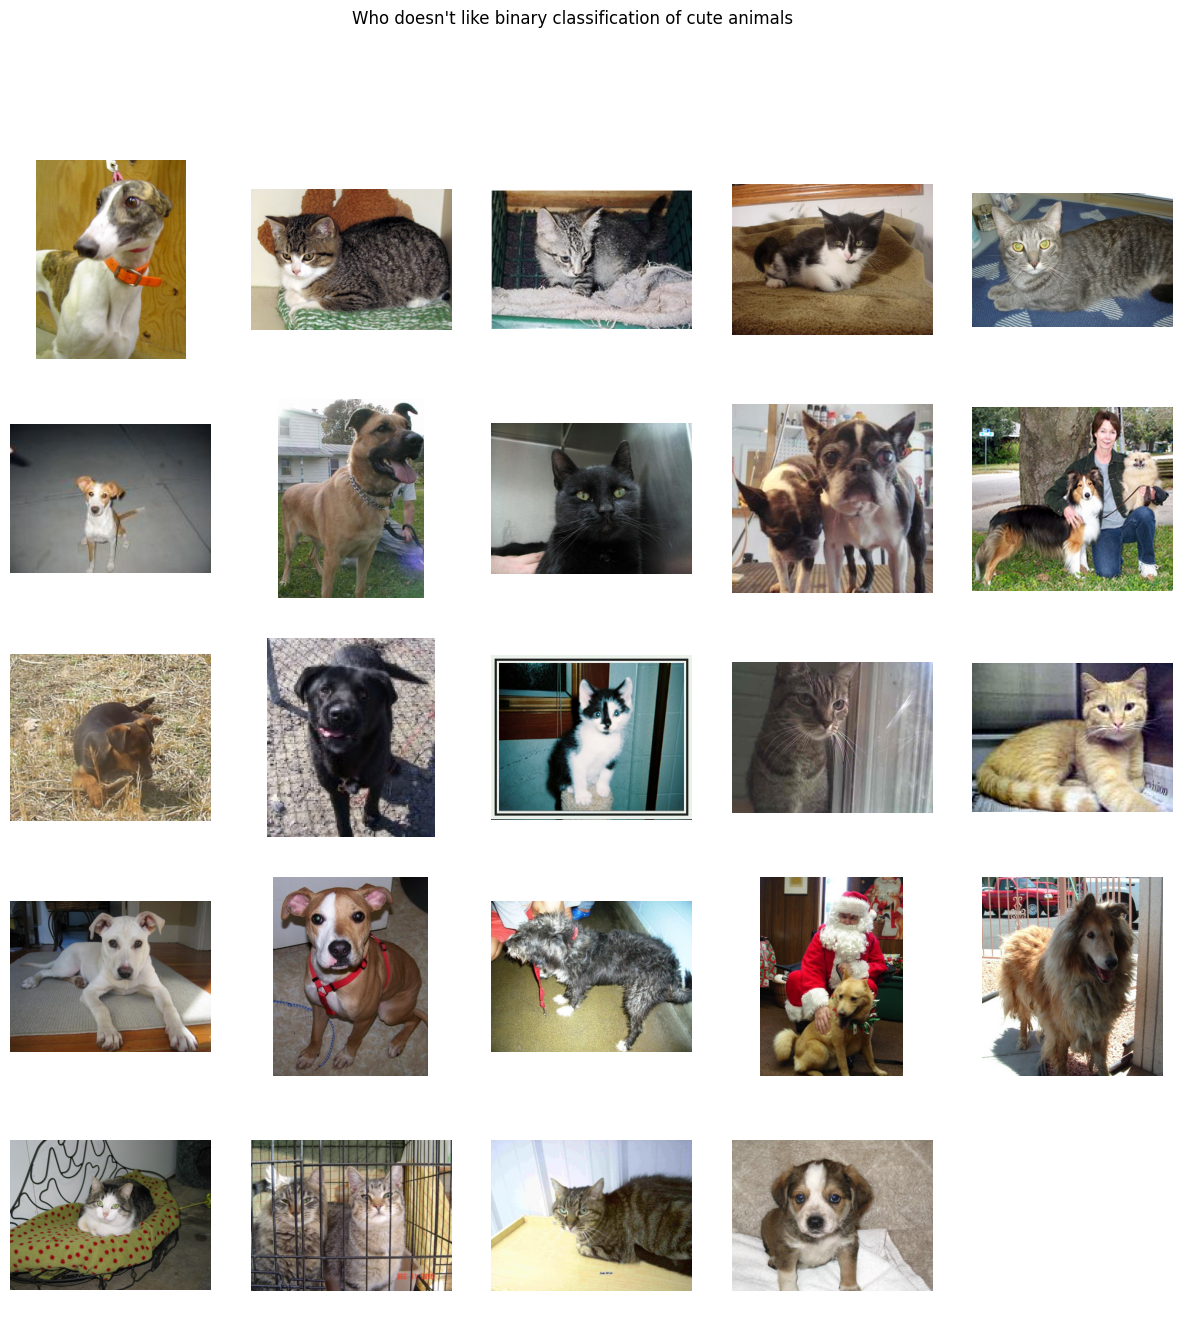

In [39]:
larger_list=[]
directory = os.path.join(os.getcwd(), 'train')

q = 1
fig,ax = plt.subplots(figsize=(15,15))
for i in range(0,(25)):
    random_file = random.choice(os.listdir(directory))
    abc=(os.path.join(directory, random_file)) #<- get the first file name
    picture = Image.open(abc) #<- reading those images
    plt.subplot(5,5,q) #<- you know that is so neat I am leaving it in
    plt.axis('off')
    title =("Who doesn't like binary classification of cute animals")
    plt.imshow(picture)
    plt.suptitle(title)
    ax.set_axis_off() 
    q+=1 #<- Make it so there are not so many files
    #print(q) #<- So I know it is not running forver
    if q ==25:
       break

# Checking for duplicate values using hashing
The average_hash function was used from the Imagehash package. https://pypi.org/project/ImageHash/
The image is first scaled down, then changed to grayscale, the means of the image colors are computed. The bits are then computed. A hash is then constructed by turning the 64 bits into a 64 bit integer. And if the results are the same, the images are likely the same.


In [ ]:
#Originally everything was in the same folder and cleaning was done in another notebook. 

directory1 = os.path.join(os.getcwd()+'train')

list_for_hashing = []
files_to_keep = []
files_to_purge = []
files_to_purge1 = []
for file in os.listdir(directory1):
    image1=imagehash.average_hash(Image.open(os.path.join(directory1,file)))
    if image1 not in list_for_hashing:
        list_for_hashing.append(image1)
        files_to_keep.append(file)
    else:
        print(file,image1)
        files_to_purge.append([file,image1])
        files_to_purge1.append(image1)

In [ ]:
zipped = list(zip(files_to_keep, list_for_hashing))
m=pd.DataFrame(zipped)
q = pd.DataFrame(files_to_purge)
pqm= q.merge(m, on = 1, how = 'inner')
file_list = list(pqm['0_x'])
file_list1 = list(pqm['0_y'])

In [ ]:
from matplotlib import pyplot as plt
larger_list=[]
directory= (os.getcwd()+'\PetImages\Cat')
q = 1
lengths1=len(pqm)
fig,ax = plt.subplots(figsize=(15,15))
for i in os.listdir(directory):
    if i in file_list:
        abc=(os.path.join(directory, i))
        picture = Image.open(abc) #<- reading those images
        plt.subplot(8,8,q) #<- you know that is so neat I am leaving it in
        plt.axis('off')
        title =("Who doesn't like binary classification of cute animals")
        plt.imshow(picture)
        plt.suptitle(title)
        ax.set_axis_off() 
        q+=1 #<- Make it so there are not so many files

In [40]:

pixel_values1=[]
widths_cat=[]
heights_cat=[]
widths_dog=[]
heights_dog=[]
traindir= directory
partial_string = 'og'
for img in os.listdir(traindir):
    if 'og' in img:
        img_path = os.path.join(traindir +'\\'+img ) # Making image file path
        im = Image.open(img_path)
        widths_dog.append(im.size[0])
        heights_dog.append(im.size[1])
        pixel_values1 = list(im.getdata())
    else:
        img_path = os.path.join(traindir +'\\'+img ) # Making image file path
        im = Image.open(img_path)
        widths_cat.append(im.size[0])
        heights_cat.append(im.size[1])
        pixel_values2 = list(im.getdata())

In [41]:
pixel_vals_b_dog = [x[0] for x in pixel_values1]
pixel_vals_g_dog = [x[1] for x in pixel_values1]
pixel_vals_r_dog = [x[2] for x in pixel_values1]
pixel_vals_b_cat = [x[0] for x in pixel_values2]
pixel_vals_g_cat = [x[1] for x in pixel_values2]
pixel_vals_r_cat = [x[2] for x in pixel_values2]

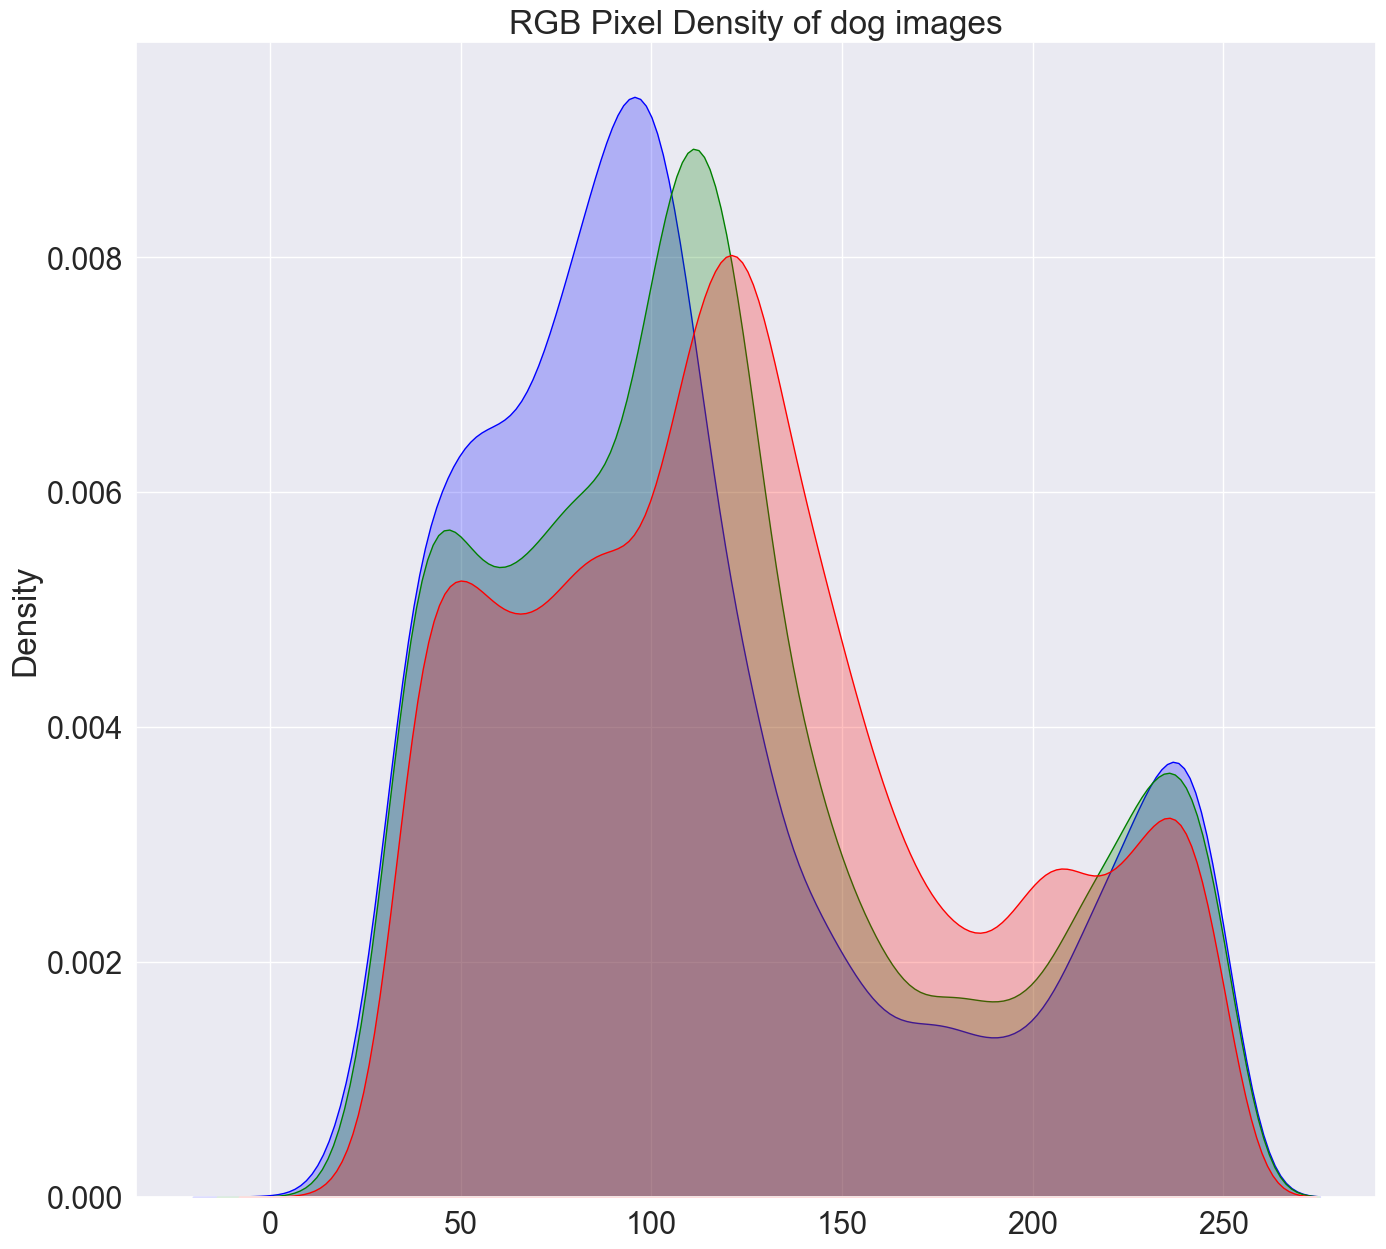

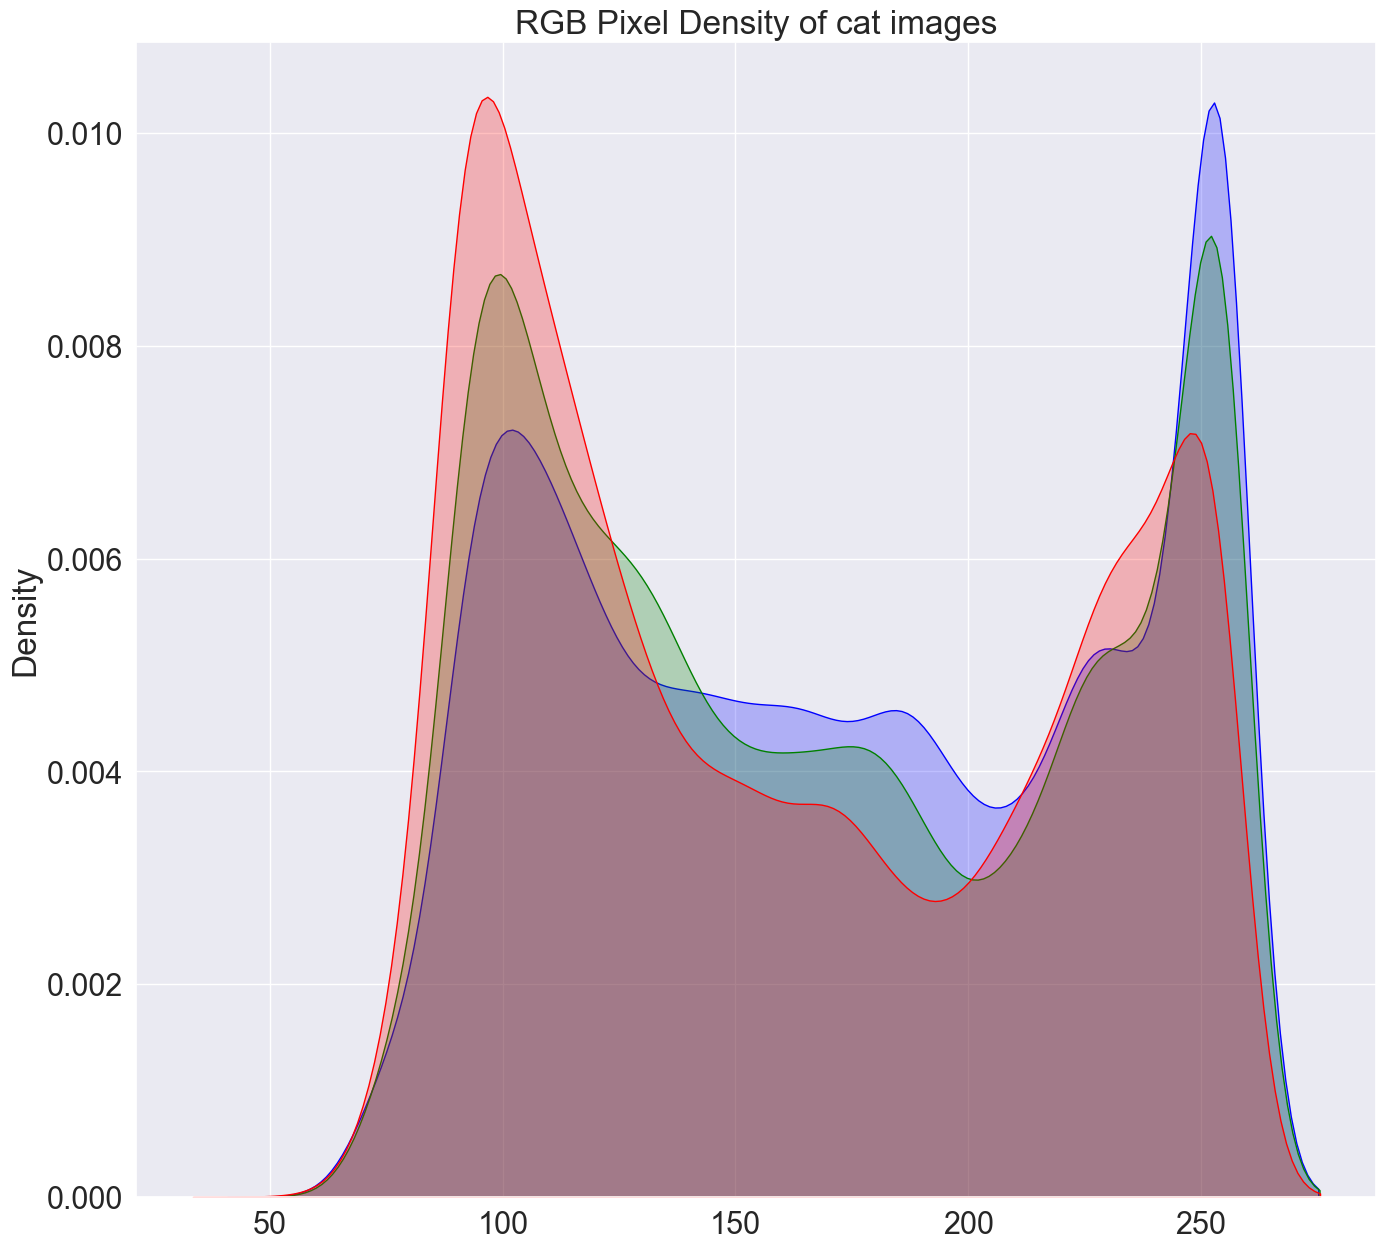

In [46]:
f,ax= plt.subplots(figsize=(16,15))
sns.set(font_scale=2.0)
sns.kdeplot(pixel_vals_b_dog, ax=ax,color='blue',fill=True).set(title='RGB Pixel Density of dog images')
sns.kdeplot(pixel_vals_g_dog, ax=ax,color='green', fill = True)
sns.kdeplot(pixel_vals_r_dog, ax=ax,color='red', fill =True)

f,ax= plt.subplots(figsize=(16,15))
sns.set(font_scale=2.0)
sns.kdeplot(pixel_vals_b_cat, ax=ax,color='blue',fill=True).set(title='RGB Pixel Density of cat images')
sns.kdeplot(pixel_vals_g_cat, ax=ax,color='green', fill = True)
sns.kdeplot(pixel_vals_r_cat, ax=ax,color='red', fill =True)
plt.show()

Images are composed of pixels. Pixels store information about their colors, in the form of 3 values. Red, green, blue. (R, G, B) When a package like imread is used to process an image, the resulting data is stored in a tuple (list?) where the first value is R, the second is G, the third is B. A plot of values from each category can provide insight about the general composition of images.

In [87]:
# Pixel values need to be in range 0/1
pixel_values1 = [50/255, 50/255, 50/255]
pixel_values2 = [100/255, 100/255, 100/255]
pixel_values3 = [150/255, 150/255, 150/255]

In [88]:
def plot_pixels(pixel_values):
    patch = plt.Rectangle((0, 0), 1, 1, color=pixel_values)
    fig, ax = plt.subplots()
    ax.add_patch(patch)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

There is a lot of density in the 50, 100, and 150 range for both sets of images. And when the colors are plotted, voilà. Many of the images contain large proportions of neutral colors.

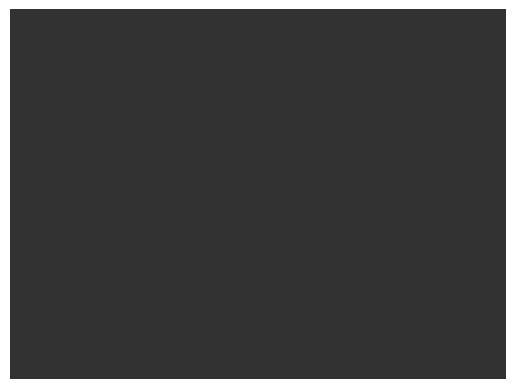

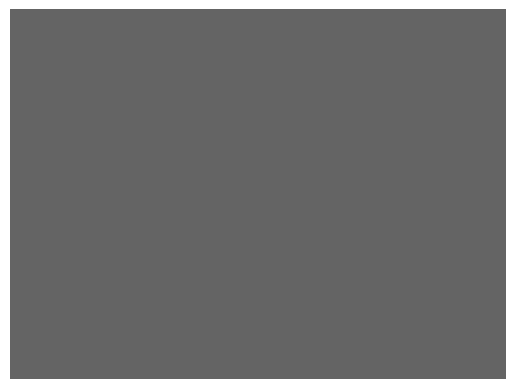

In [89]:

plot_pixels(pixel_values1), plot_pixels(pixel_values2)
plt.show()

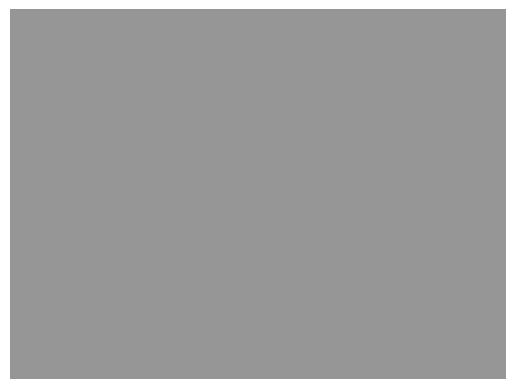

In [90]:
plot_pixels(pixel_values3)

# Are dog or cat images generally larger?
Most images for both categories are generally on the larger side. Most heights cluster around 350 pixels for both cat and dog images. While many of the images are about 500 pixels high. 

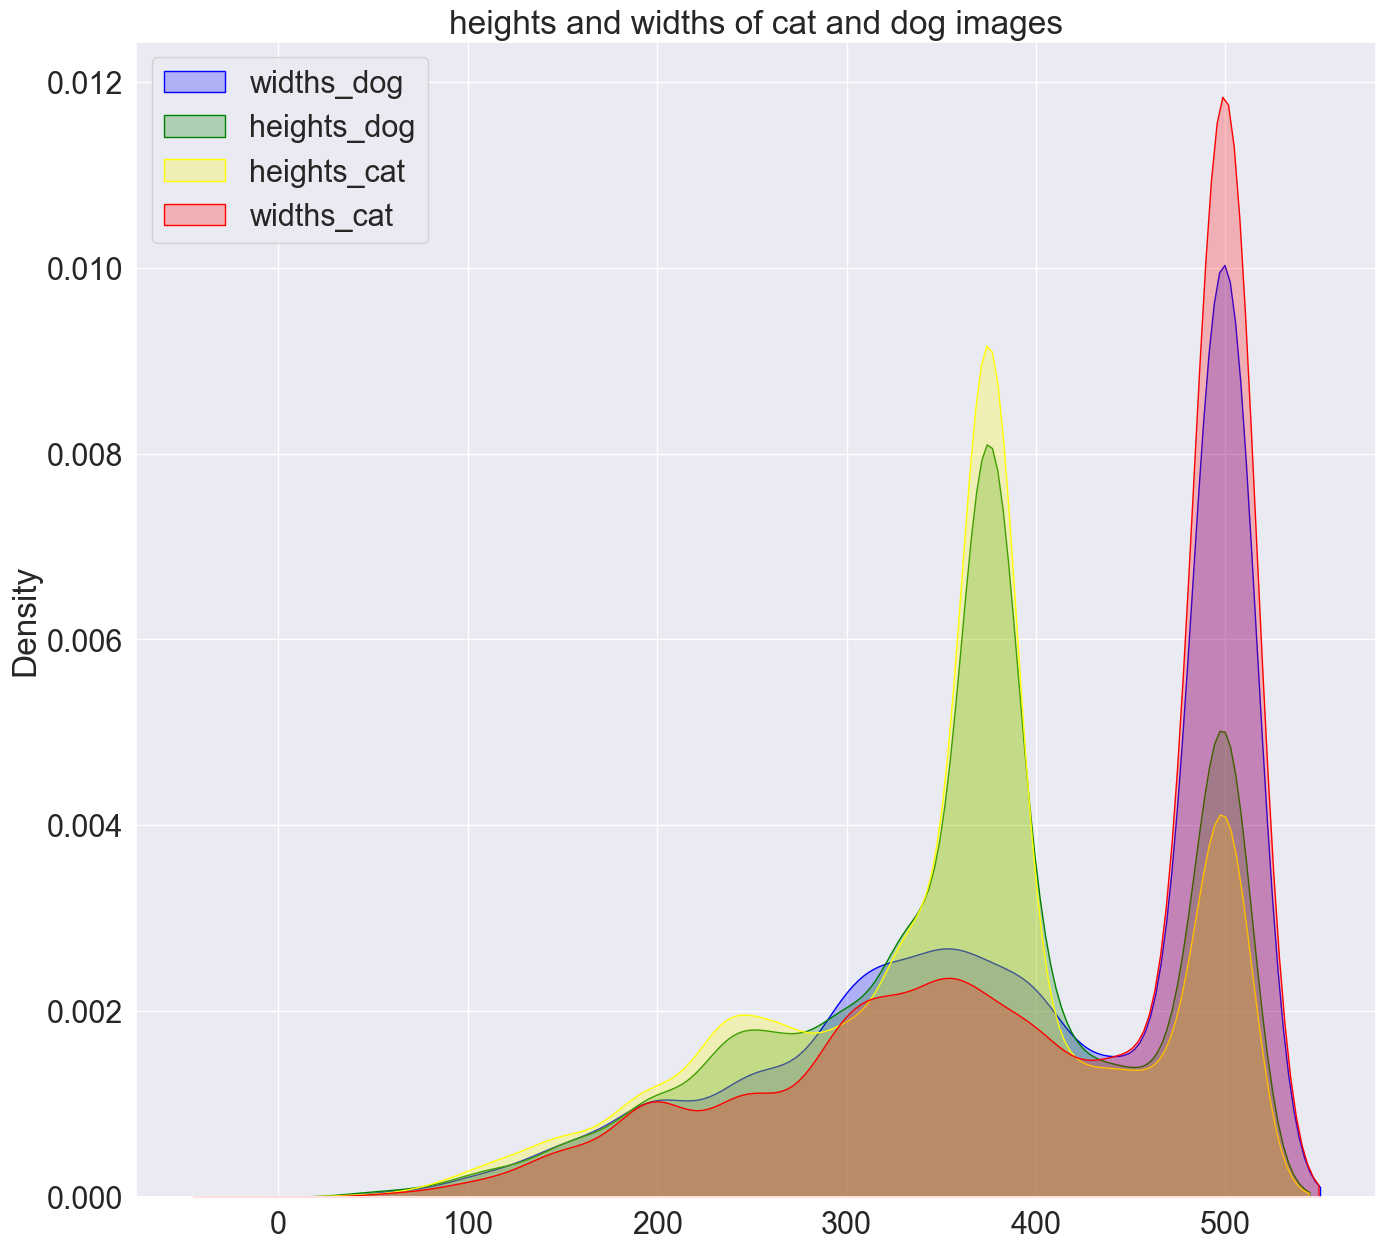

In [118]:
f,ax= plt.subplots(figsize=(16,15))
sns.kdeplot(widths_dog, ax=ax,color='blue',fill=True).set(title=
'heights and widths of cat and dog images')
sns.kdeplot(heights_dog, ax=ax,color='green', fill = True)
sns.kdeplot(heights_cat, ax=ax,color='yellow', fill = True)
sns.kdeplot(widths_cat, ax=ax,color='red', fill = True)
plt.legend(['widths_dog','heights_dog','heights_cat','widths_cat'],loc='upper left')
plt.show()

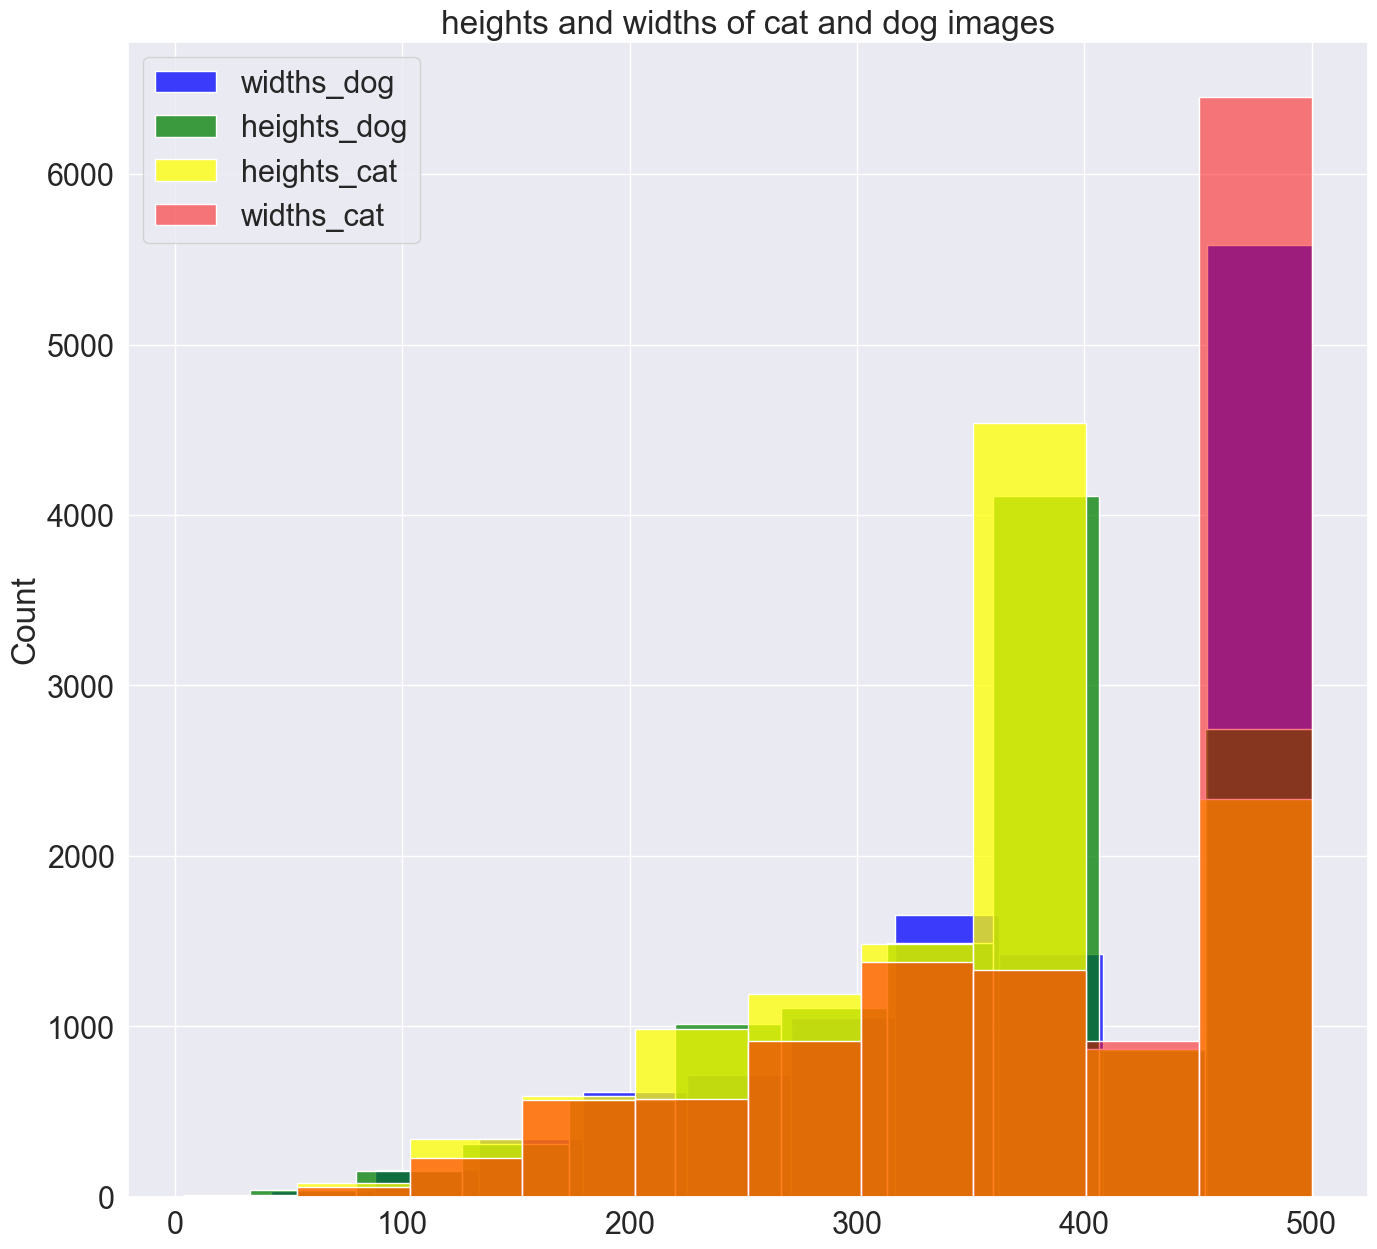

In [119]:
f,ax= plt.subplots(figsize=(16,15))
sns.histplot(widths_dog, ax=ax,color='blue',fill=True, bins =10).set(title=
'heights and widths of cat and dog images')
sns.histplot(heights_dog, ax=ax,color='green', fill = True,bins=10)
sns.histplot(heights_cat, ax=ax,color='yellow', fill = True,bins=10)
sns.histplot(widths_cat, ax=ax,color='red', fill = True,alpha= 0.5,bins=10)
plt.legend(['widths_dog','heights_dog','heights_cat','widths_cat'],loc='upper left')
plt.show()

[Text(0.5, 1.0, 'widths of dog images')]

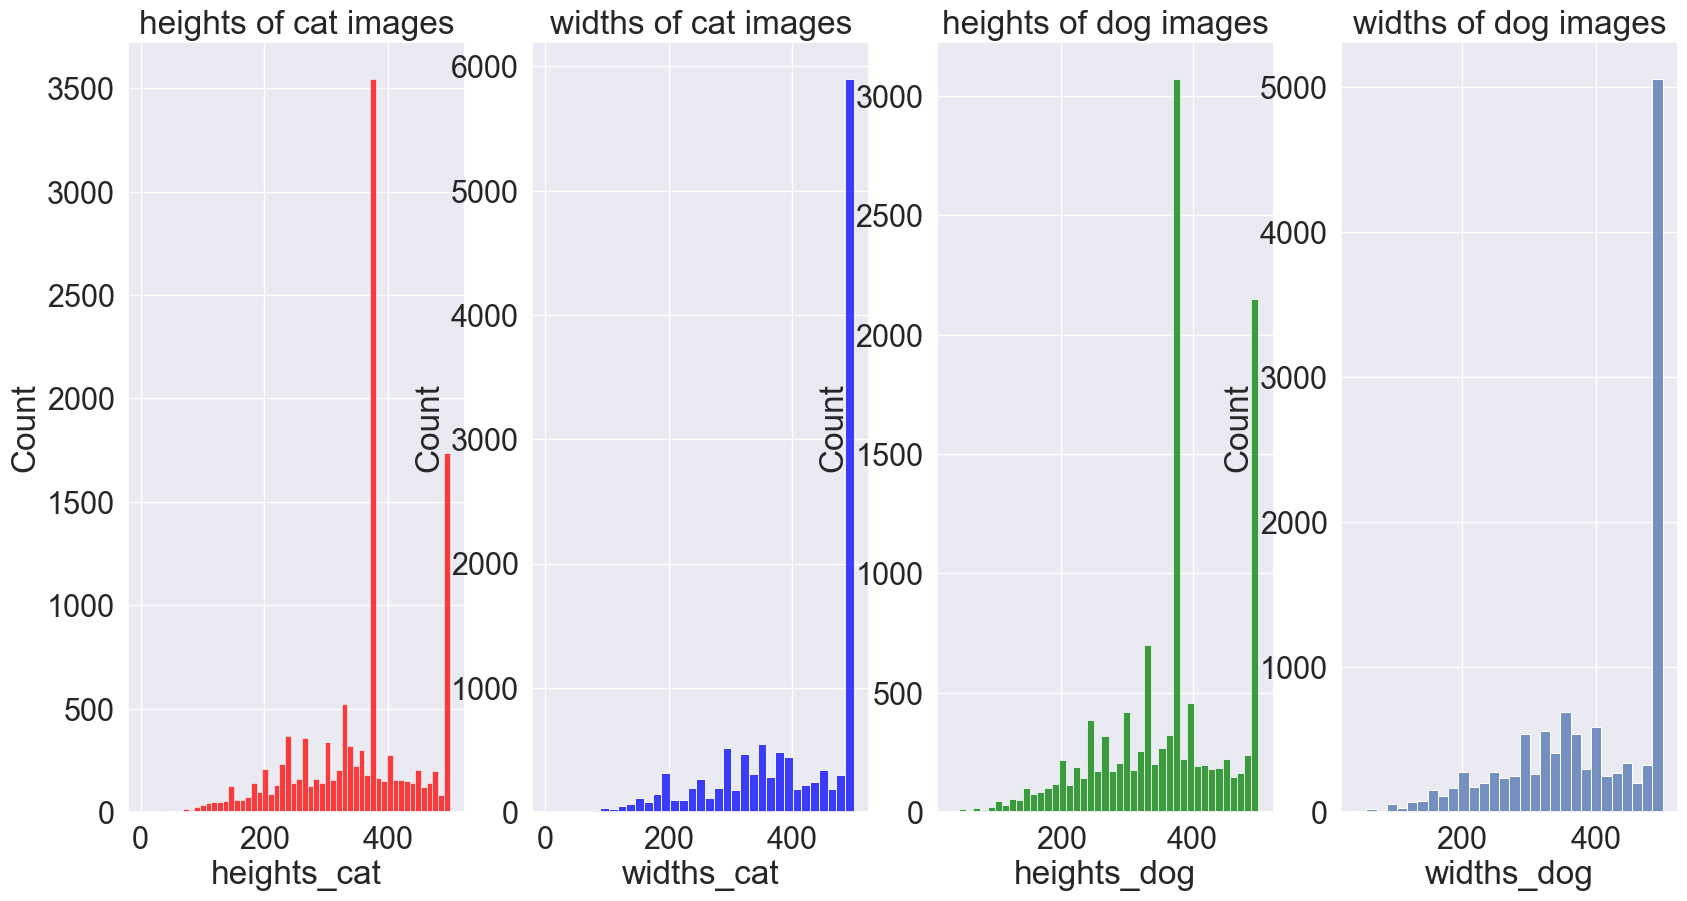

In [131]:
f,axes = plt.subplots(1, 4,figsize=(20,10))
cats_heights1 = pd.DataFrame(heights_cat,columns=['heights_cat'])
cats_width1 = pd.DataFrame(widths_cat,columns=['widths_cat'])
dogs_heights1=pd.DataFrame(heights_dog,columns=['heights_dog'])
dogs_width1=pd.DataFrame(widths_dog,columns=['widths_dog'])
sns.histplot(cats_heights1, x="heights_cat",ax=axes[0], color='red').set(title="heights of cat images")
sns.histplot(cats_width1, x="widths_cat",ax=axes[1],color='blue').set(title="widths of cat images")
sns.histplot(dogs_heights1, x="heights_dog",ax=axes[2],color='green').set(title="heights of dog images")
sns.histplot(dogs_width1, x="widths_dog",ax=axes[3]).set(title="widths of dog images")

The subplots help illustrate the spread of image sizes. All sets of images have one category that is as large as the sum of all of the others. The largest categories for heights are the same for both cat and dog images. About 400 pixels and 500 respectively. And both have similar counts for each, about 3500 images at about 400 pixels high and about 2000 at 500 pixels for cats. Versus about 3000 images at 400 pixels and about 2000 images at 500 pixels for dogs. 
Widths exibit a similar pattern, both cat and dog images cluster at about 500 pixels for the most frequent category. With cat images at this size numbering almost 6000, and dog images trailing closely behind at about 5000.

# What about the balance of samples? 
How many classes are  found in each data set?
Since the problem is binary, the images fall into categories of 0 or 1.

In [145]:
print(' There are:', len(xy1['status'].unique()), 'categories in the training data set','\n',
'There are:', len(xy2['status'].unique()), 'categories in the validation data set','\n',
'There are:', len(xy3['status'].unique()), 'categories in the test data set')

 There are: 2 categories in the training data set 
 There are: 2 categories in the validation data set 
 There are: 2 categories in the test data set


Not surprisingly, there are two categories in each data set.
How about the numbers of samples?


In [154]:
print('Training data:', 'images in the 0 category : ',len(xy1[xy1['status']==0]),"," 
      ,'images in the 1 category :',len(xy1[xy1['status']==1]) )
print('Validation data:', 'images in the 0 category:',len(xy2[xy2['status']==0]),"," 
      ,'images in the 1 category:',len(xy2[xy2['status']==1]) )
print('Test data:', 'images in the 0 category:',len(xy3[xy3['status']==0]),"," 
      ,'images in the 1 category:',len(xy3[xy3['status']==1]) )

Training data: images in the 0 category :  12418 , images in the 1 category : 12418
Validation data: images in the 0 category: 40 , images in the 1 category: 40
Test data: images in the 0 category: 40 , images in the 1 category: 40


A pie chart is created for illustrative purposes

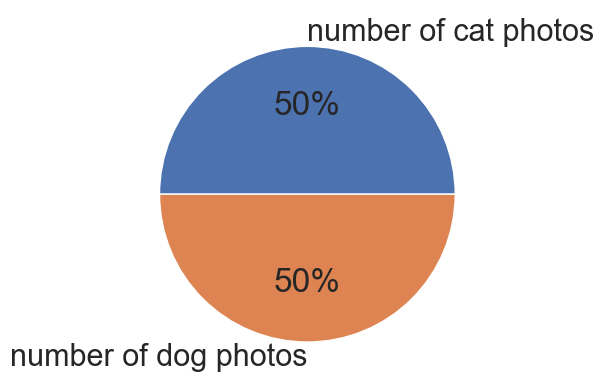

In [94]:
data=[len(heights_cat),len(heights_dog)]
keys='number of cat photos','number of dog photos'
plt.pie(data, labels=keys,autopct='%.0f%%')
plt.show()

## Procedure


Setting the device to cuda, so the GPU can be utilized. 

In [10]:
print(torch.__version__)

2.1.0+cu121


In [11]:
device = torch.device('cuda') 

In [12]:
device

device(type='cuda')

Creating lists, one for training, validation and testing, appending relevant file names to each.

In [5]:
# Loading data
#For training

starter_path = os.path.join(os.getcwd(), 'train')
data_labels_tr = []
next_path = os.listdir(starter_path)

for i in next_path:
    impath = (os.path.join(starter_path, i))
    data_labels_tr.append(i)

#For validation
starter_path = os.path.join(os.getcwd(), 'val')
data_labels_val = []
next_path = os.listdir(starter_path)

for i in next_path:
    impath = (os.path.join(starter_path, i))
    data_labels_val.append(i)

#For testing
starter_path = os.path.join(os.getcwd(), "test")
data_labels_tst = []
next_path = os.listdir(starter_path)

for i in next_path:
    impath = (os.path.join(starter_path, i))
    data_labels_tst.append(i)

In [6]:
# A lazyish way of creating labels for a binary classification task. Put a 0 if the file contains a partial name
partial_string = 'og'
xy1=pd.DataFrame(data_labels_tr)
xy2=pd.DataFrame(data_labels_val)
xy3=pd.DataFrame(data_labels_tst)
xy1['status'] = xy1[0].str.contains(partial_string).astype(int)
xy2['status'] = xy2[0].str.contains(partial_string).astype(int)
xy3['status'] = xy3[0].str.contains(partial_string).astype(int)
xy1.columns=['id','status']
xy2.columns=['id','status']
xy3.columns=['id','status']

All data is saved to csv files, which will overwrite whatever is in the directory if it exists. 

In [7]:
# Save to csv files in the current directory
xy1.to_csv("training_labels_final.csv",index=False)
xy2.to_csv("val_labels_final.csv",index=False)
xy3.to_csv("test_labels_final.csv",index=False)

Resizing images, flipping them and turning them into tensors. 

In [20]:
## Transformer
img_transforms = v2.Compose([v2.Resize((64,64)),
                             v2.RandomHorizontalFlip(p=0.5),
                             v2.RandomPhotometricDistort(p=0.5),
                            v2.ToTensor()])

In [12]:
# Custom data loaders for training validation testing
# Loads all images and puts them into either lists or into data dictionaries. 

class Loading_training(Dataset):
    
    def __init__(self):
        """Loading various data sets 
        but only in existing train, val test folders."""
        self.selected_dataset_dir = os.path.join(os.path.join(os.getcwd(), "train"))
        self.all_filenames = os.listdir(self.selected_dataset_dir)
        self.all_labels = pd.read_csv(os.path.join(os.getcwd(), 'training_labels_final.csv'))
        self.label_meanings = self.all_labels.columns.values.tolist()


    def __len__(self):
        """Weird"""
        return len(self.all_filenames)


    def __getitem__(self, idx):
        img_path = os.path.join(self.selected_dataset_dir, self.all_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.all_labels.iloc[idx, 1]
        label = torch.tensor(label)
        image = img_transforms(image)
        return image, label


class Loading_val(Dataset):
    
    def __init__(self):
        """Trying to load jpeg transformed Dicam files."""
        self.selected_dataset_dir = os.path.join(os.getcwd(), "val")
        self.all_filenames = os.listdir(self.selected_dataset_dir)
        self.all_labels = pd.read_csv(os.path.join(os.getcwd(), 'val_labels_final.csv'))
        self.label_meanings = self.all_labels.columns.values.tolist()


    def __len__(self):
        """Weird"""
        return len(self.all_filenames)


    def __getitem__(self, idx):
        img_path = os.path.join(self.selected_dataset_dir, self.all_labels.iloc[idx, 0])
        image =  Image.open(img_path).convert("RGB")
        label = self.all_labels.iloc[idx, 1]
        label = torch.tensor(label)
        image = img_transforms(image)
        return image, label

    
class Loading_test(Dataset):

    def __init__(self):
        """Loading test images."""
        self.selected_dataset_dir = os.path.join(os.getcwd(), "test")
        self.all_filenames = os.listdir(self.selected_dataset_dir)
        self.all_labels = pd.read_csv(os.path.join(os.getcwd(),'test_labels_final.csv'))
        self.label_meanings = self.all_labels.columns.values.tolist()


    def __len__(self):
        """Weird"""
        return len(self.all_filenames)


    def __getitem__(self, idx):
        """The IDX function is built in to Pytorch. Pretty Cool I think.
        And then I use the above image transforms function"""
        selected_filename = self.all_filenames[idx]
        #print(selected_filename)
        imagepil = Image.open(os.path.join(self.selected_dataset_dir, selected_filename)).convert("RGB")
        image = img_transforms(imagepil)
        self.all_labels = pd.read_csv(os.path.join(os.getcwd(), 'test_labels_final.csv'))
        label= self.all_labels['status'][idx]


        sample = {'data':image, 
                  'label':label,
                  'img_idx':idx, 'sample_name':selected_filename}
        return(sample)

In [13]:
class Modelo(nn.Module):
    
    def __init__(self):
        super(Modelo, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            #torch.nn.Dropout2d(p=0.2),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1,bias=False),
            nn.BatchNorm2d(32, affine=False),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.LeakyReLU(inplace=True,negative_slope=0.02))
        self.main1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
        torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
        torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
        torch.nn.Dropout2d(p=0.2),
        torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1),
        torch.nn.LeakyReLU(inplace=True,negative_slope=0.02))
        self.main2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
        torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
        torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
        torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=1),
        #torch.nn.MaxPool2d(2, 2),
        torch.nn.LeakyReLU(inplace=True,negative_slope=0.02))
        self.main3 = torch.nn.Sequential(
        torch.nn.Dropout2d(p=0.2),
        torch.nn.Conv2d(in_channels=8, out_channels=2, kernel_size=(3, 3), padding=1),
        torch.nn.MaxPool2d(2, 2),
        torch.nn.LeakyReLU(inplace=True,negative_slope=0.1))
        self.fc4 = nn.Linear(in_features=512,out_features=256)
        self.fc5 = nn.Linear(in_features=256,out_features=128)
        self.fc6 = nn.Linear(in_features=128,out_features=1)

    def forward(self, x):
        x = self.main(x)
        x = self.main1(x)
        x = self.main2(x)
        x = self.main3(x)
        x = torch.flatten(x,start_dim=1,end_dim=-1)
        #x = self.fc1(x)
        #x = self.fc2(x)
        #x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        return x


model = Modelo().to(device)


import torchvision
from torchview import draw_graph



In [ ]:

training1=Loading_training()
val1=Loading_val()
test1= Loading_test()


train_dataloader = DataLoader(training1, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val1, batch_size=10, shuffle=True)

In [10]:
loss_fn_=nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0000050)

The below code will run training and test the data on validation data,
then it will save the best X models based on accuracy to a folder called checkpoint.


In [17]:
def update_model(engine, batch):
    model.train()
    data,label = batch
    optimizer.zero_grad()
    data=data.to(device)
    label=label.to(device)
    #print(label.get_device())
    #print(data.get_device())
    outputs,_=(model(data),label)
    outputs=outputs.squeeze()
    loss = loss_fn_(outputs, label.float())
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(update_model)


val_metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(loss_fn_)
}


def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x=x.to(device)
        y=y.to(device)
        outputs,_=(model(x),y)
        outputs = outputs.squeeze()
        outputs=torch.sigmoid(outputs)
        outputs=outputs.round()
        y=y.cpu().detach()

    return outputs, y.float()
    
    
evaluator = Engine(validation_step)


from ignite.metrics import Accuracy
from ignite.metrics import Precision, Recall

precision = Precision()


Accuracy().attach(evaluator, "accuracy")
Precision().attach(evaluator,'precision')
Recall(average='weighted').attach(evaluator,'recall')


    

@trainer.on(Events.ITERATION_COMPLETED(every=100))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]['lr']
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    print("Epoch {}/{} : {} - batch loss: {}, lr: {}".format(e, n, i, batch_loss, lr))
    
    
    
    
    
from ignite.handlers import Timer, BasicTimeProfiler, HandlersTimeProfiler    
from ignite.engine import Events

validate_every = 5


@trainer.on(Events.EPOCH_COMPLETED(every=validate_every))
def run_validation():
    evaluator.run(val_dataloader)
    
@trainer.on(Events.EPOCH_COMPLETED(every=validate_every))
def log_validation():
    ugh=[]
    metrics = evaluator.state.metrics
    print(f"Epoch: {trainer.state.epoch},  Accuracy: {metrics['accuracy']},  Precision: {metrics['precision']}, recall: {metrics['recall']}")


def score_function(engine):
    return engine.state.metrics["accuracy"]


model_checkpoint = ModelCheckpoint(
    "checkpoint",
    n_saved=25,
    filename_prefix="best",
    score_function=score_function,
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
  
evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": model})

tb_logger = TensorboardLogger(log_dir="tb-logger")

tb_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED(every=100),
    tag="training",
    output_transform=lambda loss: {"batch_loss": loss},
)

for tag, evaluator in [("training", trainer), ("validation", evaluator)]:
    tb_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names="all",
        global_step_transform=global_step_from_engine(trainer),
    )

trainer.run(train_dataloader, max_epochs=200)

Epoch 1/200 : 100 - batch loss: 0.6717314720153809, lr: 5e-06
Epoch 1/200 : 200 - batch loss: 0.62602299451828, lr: 5e-06
Epoch 1/200 : 300 - batch loss: 0.5983356833457947, lr: 5e-06
Epoch 2/200 : 400 - batch loss: 0.620399534702301, lr: 5e-06
Epoch 2/200 : 500 - batch loss: 0.6466283798217773, lr: 5e-06
Epoch 2/200 : 600 - batch loss: 0.6703633069992065, lr: 5e-06
Epoch 2/200 : 700 - batch loss: 0.6332987546920776, lr: 5e-06
Epoch 3/200 : 800 - batch loss: 0.5965307950973511, lr: 5e-06
Epoch 3/200 : 900 - batch loss: 0.5554847121238708, lr: 5e-06
Epoch 3/200 : 1000 - batch loss: 0.6473831534385681, lr: 5e-06
Epoch 3/200 : 1100 - batch loss: 0.6285393238067627, lr: 5e-06
Epoch 4/200 : 1200 - batch loss: 0.546758234500885, lr: 5e-06
Epoch 4/200 : 1300 - batch loss: 0.6762315034866333, lr: 5e-06
Epoch 4/200 : 1400 - batch loss: 0.544600784778595, lr: 5e-06
Epoch 4/200 : 1500 - batch loss: 0.6425125598907471, lr: 5e-06
Epoch 5/200 : 1600 - batch loss: 0.6203905344009399, lr: 5e-06
Epoch 

State:
	iteration: 77800
	epoch: 200
	epoch_length: 389
	max_epochs: 200
	output: 0.21232636272907257
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [11]:
from torcheval.metrics.functional import binary_accuracy

from torcheval.metrics.functional.classification import binary_recall
from torcheval.metrics.functional.aggregation.auc import auc
from torcheval.metrics.functional import binary_precision
from torcheval.metrics.functional import binary_accuracy
from torcheval.metrics.functional import binary_f1_score
from sklearn.metrics import roc_curve

In [23]:
test_dataloader = DataLoader(test1, batch_size=80, shuffle=True)

Illustration of the balance of cat and dog photos

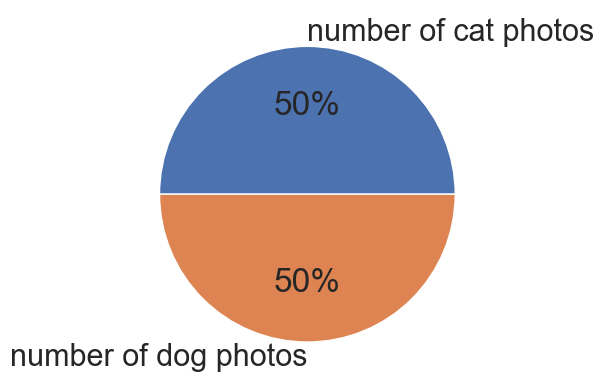

In [ ]:
data=[len(heights_cat),len(heights_dog)]
keys='number of cat photos','number of dog photos'
plt.pie(data, labels=keys,autopct='%.0f%%')
plt.show()

## Testing and results

In [24]:
new_dir = os.path.join(os.getcwd(),'models_1')


In [35]:
torch.manual_seed(0)
accuracy10=[]
roc_things=[]

from torcheval.metrics.functional import binary_accuracy

from torcheval.metrics.functional.classification import binary_recall
from torcheval.metrics.functional.aggregation.auc import auc
from torcheval.metrics.functional import binary_precision
from torcheval.metrics.functional import binary_accuracy
from torcheval.metrics.functional import binary_f1_score
from sklearn.metrics import roc_curve
new_dir = os.path.join(os.getcwd(),'models_1')
for j in os.listdir(new_dir):
    PATH=os.path.join(new_dir,j)
    model.load_state_dict(torch.load(PATH))
    for i, batch in enumerate(test_dataloader):
        model.eval()
        data,label = batch['data'].float(),batch['label']
        data = data.to(device)
        label = label.to(device)
        y_logits,label = (model(data),label)
        test_pred = y_logits.squeeze(-1)
        test_pred = torch.sigmoid(test_pred)
        test_pred = test_pred.cpu().detach()
        test_pred = test_pred.round()
        test_pred1 = test_pred.cpu().detach()
        label = label.cpu().detach()
        fpr, tpr, threshold = roc_curve(label.float(), test_pred1)
        
        bina_acc = binary_accuracy(test_pred, label, threshold=0.7)
        bin_acc = bina_acc.detach().numpy()
        
        f1_score1 = binary_f1_score(test_pred, label, threshold=0.61)
        f1_score = f1_score1.detach().numpy()
        
        bin_rec1 = binary_recall(test_pred, label, threshold=0.61)
        bin_rec = bin_rec1.detach().numpy()
        
        bin_prec1 = binary_precision(test_pred, label, threshold=0.61)
        bin_prec = bin_prec1.detach().numpy()
        
        accuracy10.append([bin_acc, f1_score,bin_rec,
                           bin_prec, j, test_pred1.numpy(),
                           label.numpy()])
        roc_things.append([fpr, tpr, threshold])
        


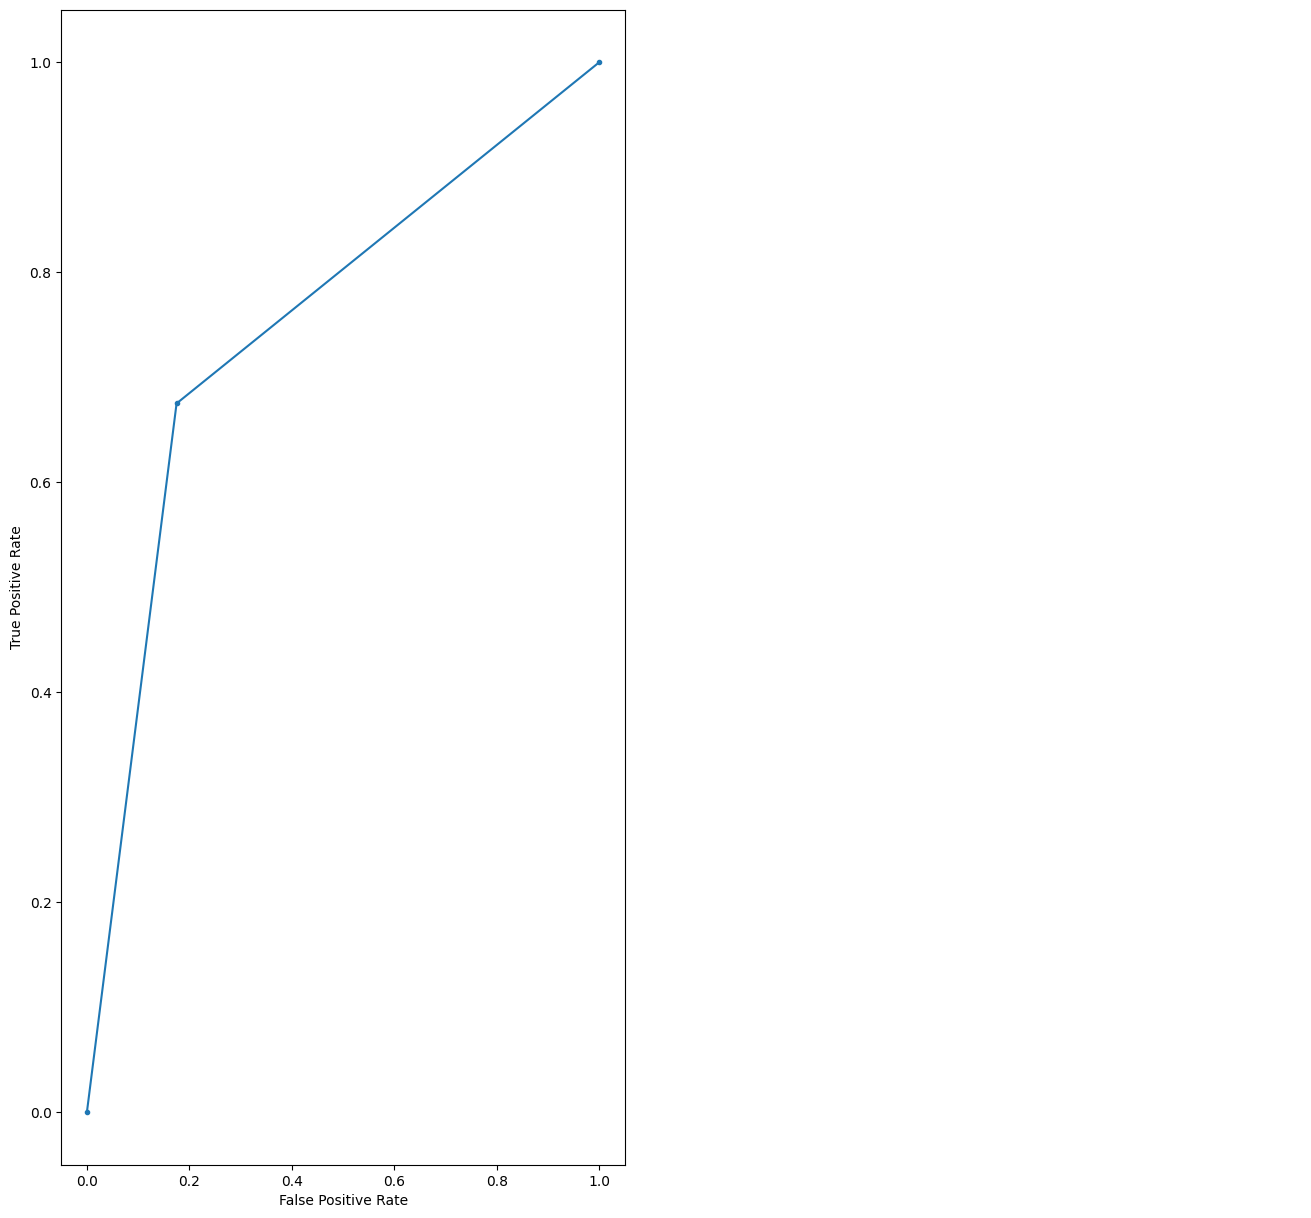

In [33]:
from matplotlib import pyplot as plt
f,ax= plt.subplots(figsize=(16,15))
plt.subplot(1,2,1)
plt.plot(fpr,tpr,marker='.')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate' )
ax.set_axis_off()

## Result visualizations

There are multiple plots for similiar metrics as a comparison of what works best

In [ ]:
ahh=pd.DataFrame(accuracy10,columns=['Accuracy','F1', 'binary_recall', 
                                     'binary_precision', 'model_info',
                                     'y_pred','y_true'])


In [2]:
ahh=pd.read_csv('model_results_training.csv')
ahh=pd.DataFrame(ahh)


In [232]:
ahh.to_csv('model_results_training.csv',index=False)

In [230]:
roc_things = pd.DataFrame(roc_things)

In [231]:
roc_things.to_csv('roc_results_for_training_data', index = False )

In [4]:
predictions = []
true_values = []
sums_of_values = []
from sklearn.metrics import confusion_matrix
import ast
from sklearn import metrics
for i in range(0,len(ahh)):
    b = ahh['y_pred'][i].replace( ' ' , ',' )
    positive_pred = ast.literal_eval(b)
    pred_pos = (np.sum(positive_pred))
    full_pred = len(positive_pred) # instead of the differences plot the sum, it will look nicer
    pred_neg = len(positive_pred) - pred_pos
    c = ahh['y_true'][i].replace( ' ' , ',' )
    
    true_positive_pred = ast.literal_eval(c)
    matrixes = (confusion_matrix(positive_pred, true_positive_pred))
    sns.heatmap(matrixes, annot=True, fmt='g', ax=ax)

    true_pos = np.sum(true_positive_pred)
    full_true = len(true_positive_pred)
    true_neg = len(true_positive_pred) - true_pos
    predictions.append([pred_pos, pred_neg, full_pred, true_pos, true_neg, full_true])
dataframe_for_micro_test = pd.DataFrame(predictions, columns=['pred_1','pred_0','sums_preds','true_1','true_0','sums_true'])
plt.show()


Confusion matrices

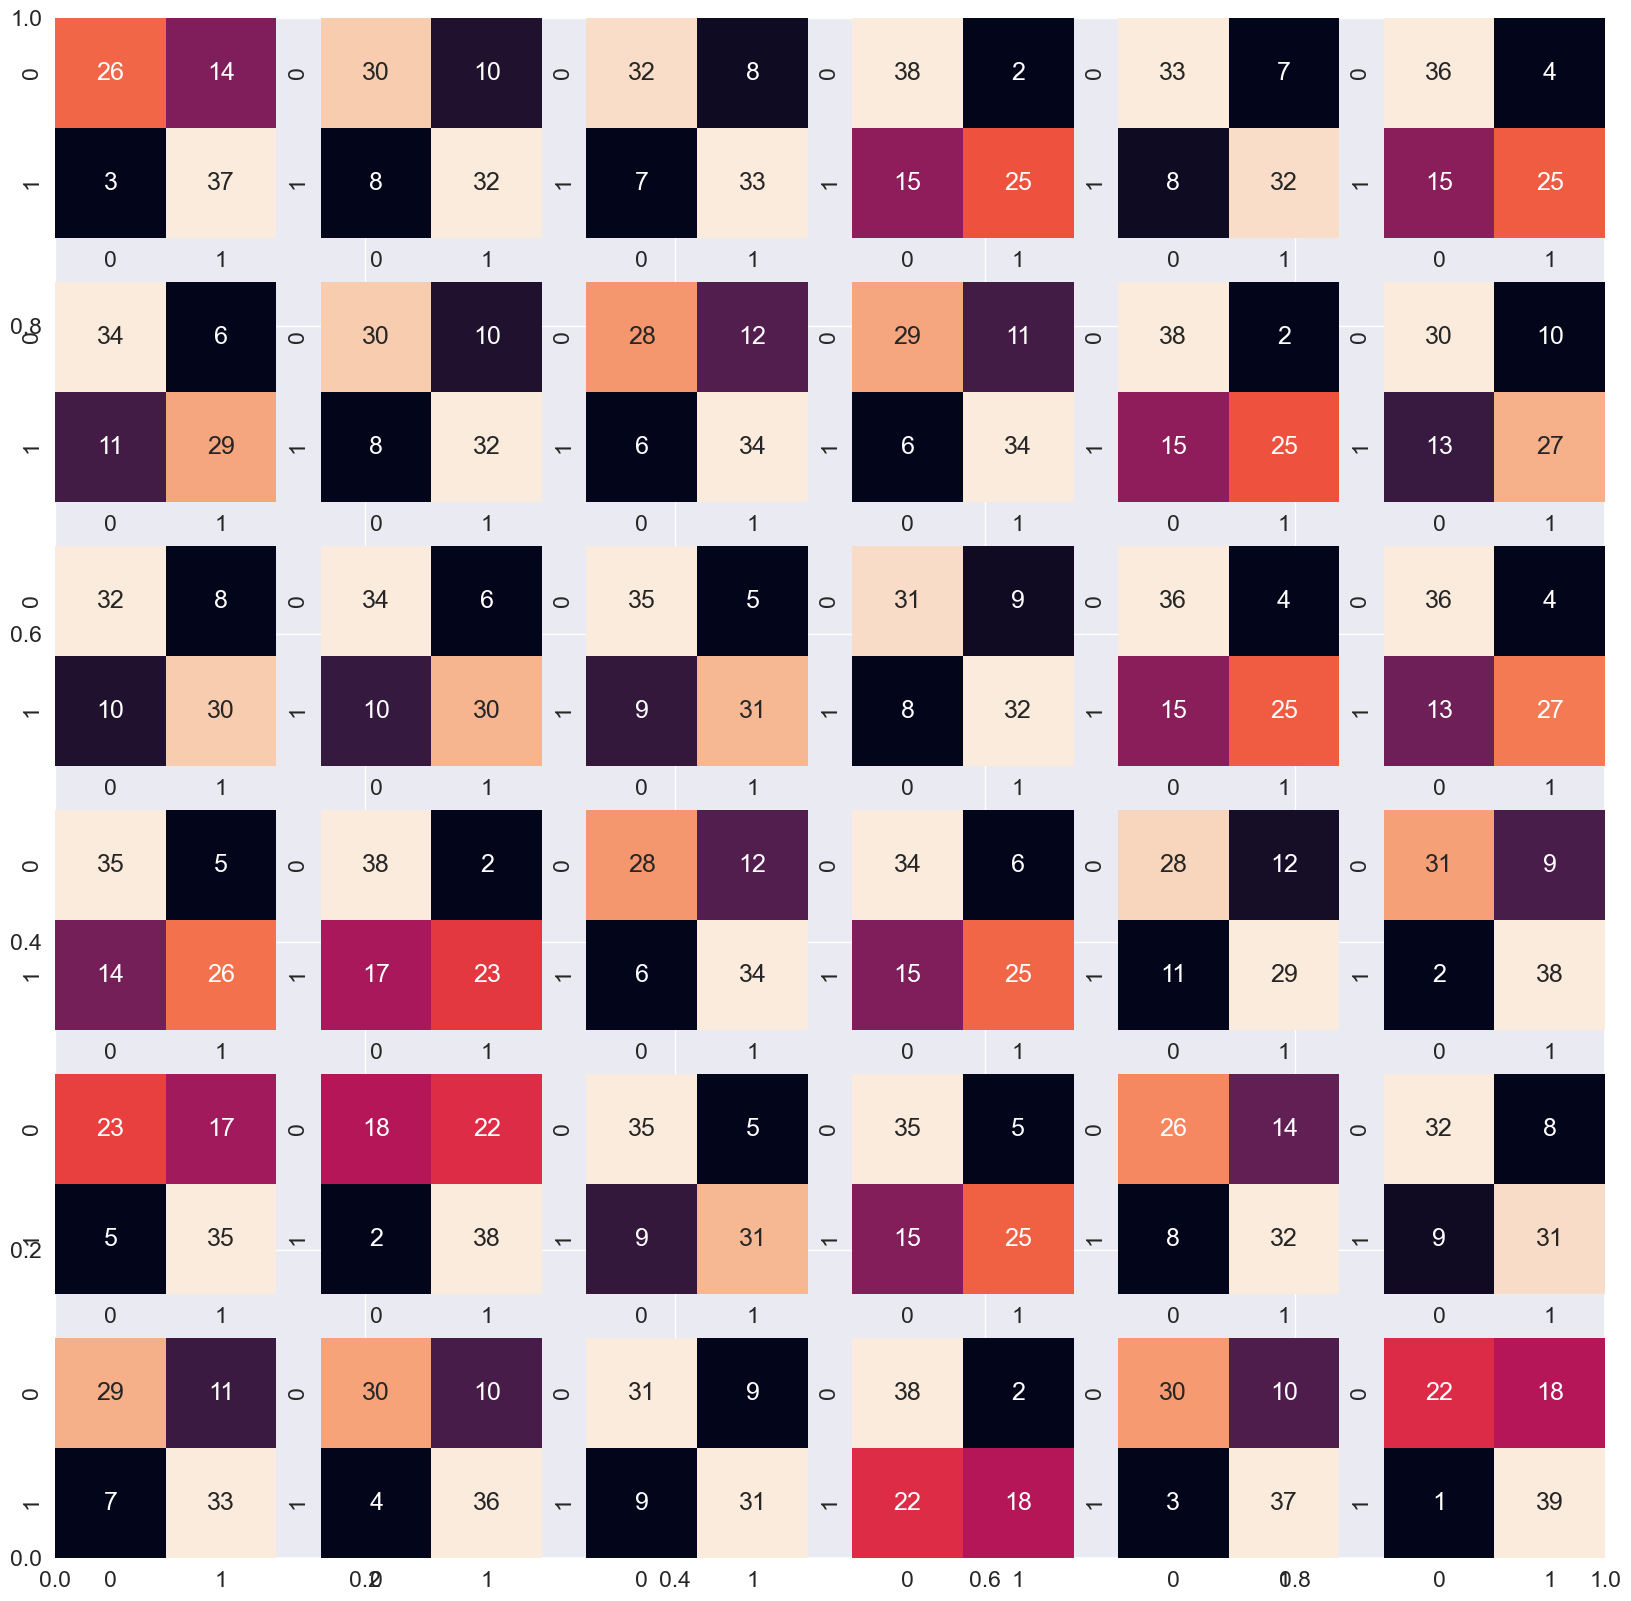

In [53]:

from sklearn.metrics import confusion_matrix
import ast
from sklearn import metrics
fig,ax = plt.subplots(figsize=(20,20))
k = 1
for i in range(0,len(ahh)-1):

    b = ahh['y_pred'][i].replace( ' ' , ',' )
    positive_pred = ast.literal_eval(b)
    c = ahh['y_true'][i].replace( ' ' , ',' )
    true_positive_pred = ast.literal_eval(c)
    matrixes = (confusion_matrix(true_positive_pred,positive_pred))
    plt.subplot(6,6,k)
    sns.heatmap(matrixes, annot=True, cbar= False)
    k +=1

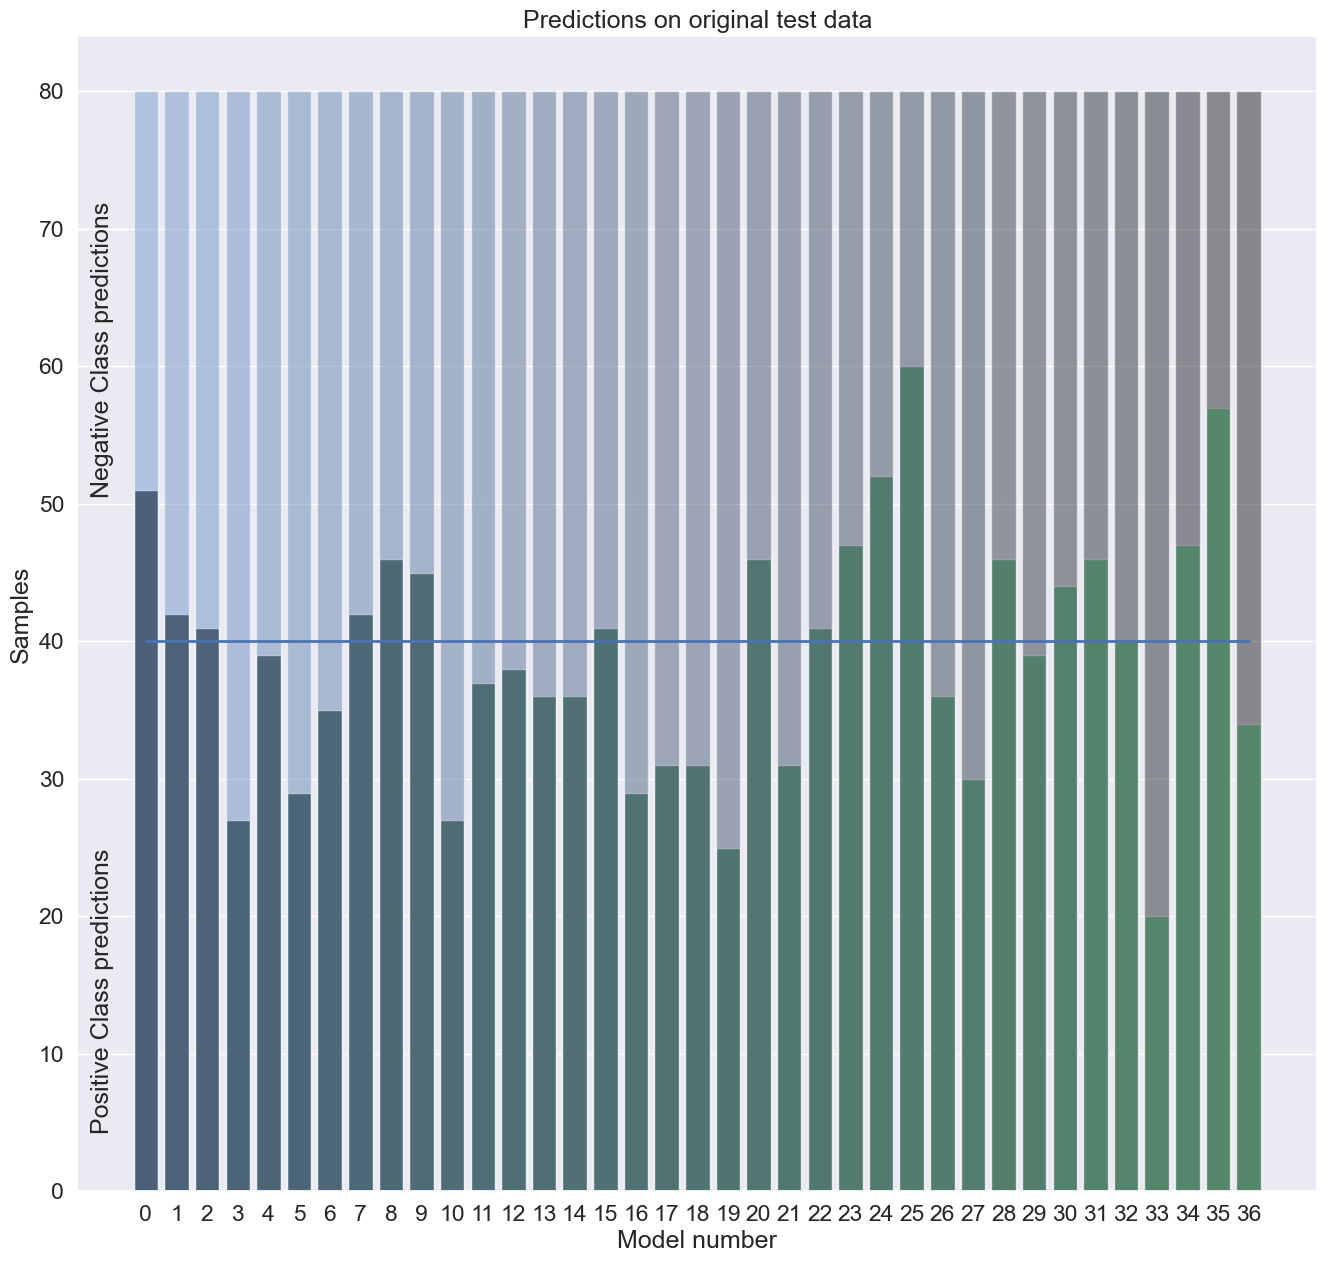

In [54]:
f,ax= plt.subplots(figsize=(16,15))
palette1 = sns.color_palette("light:#5A9", as_cmap=True)
sns.barplot(x=dataframe_for_micro_test.index, y="pred_1", data = dataframe_for_micro_test, 
            hue= dataframe_for_micro_test.index, ax = ax, legend= False, color = '#76fda8').set_title(('Predictions on original test data'))
sns.barplot(x=dataframe_for_micro_test.index, y="sums_preds", data=dataframe_for_micro_test,
            hue= dataframe_for_micro_test.index, ax = ax, alpha = 0.5, legend= False,palette = sns.dark_palette("#69d", reverse=True, as_cmap=True))
plt.plot([0, 36], [40, 40], linewidth=2)
plt.text(0.02, 0.05, 'Positive Class predictions',
     horizontalalignment='center',
     verticalalignment='bottom', rotation ='vertical',
     transform = ax.transAxes)
plt.text(0.02, 0.6, 'Negative Class predictions',
     horizontalalignment='center',
     verticalalignment='bottom', rotation ='vertical',
     transform = ax.transAxes)
ax.set(xlabel= 'Model number', ylabel='Samples')
sns.set(font_scale=1.4)
plt.show()

# Okay so these models do pretty well actually. I am quite excited about that.


And now I am going to just get random data and test to see how these models do. 


https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification


In [14]:
#The below chunks make little data frames of all of the files we just split up. 
#For testing

starter_path=os.path.join(os.getcwd(),'completely_new_images_sources_from_Kaggle\\test')
data_labels_tst=[]
next_path= os.listdir(starter_path)
#after_that = os.path.join(starter_path,next_path[0])
#now_test= os.listdir(after_that)
for i in next_path:
    impath=(os.path.join(starter_path,i))
    data_labels_tst.append(i)

In [15]:
partial_string = 'og'

xy4=pd.DataFrame(data_labels_tst)
xy4['status'] = xy4[0].str.contains(partial_string).astype(int)
xy4.columns=['id','status']
xy4.to_csv("test_labels_final_1.csv",index=False)

In [16]:
import torch
from torch.utils.data import Dataset

from torchvision.transforms import ToTensor

import os
import pandas as pd
from torchvision.io import read_image
import pandas as pd
import numpy as np





class Loading_test1(Dataset):
    
    def __init__(self):
        """Trying to load jpeg transformed Dicam files.
        """
        #Define dataset
        #overall_dataset_dir = control_dir
        
        self.selected_dataset_dir = os.path.join(os.getcwd(),"\\completely_new_images_sources_from_Kaggle\\test")
        self.all_filenames = os.listdir(os.getcwd()+"\\completely_new_images_sources_from_Kaggle\\test")
        self.all_labels = pd.read_csv(os.path.join(os.getcwd(),'test_labels_final_1.csv'))
        self.label_meanings = self.all_labels.columns.values.tolist()
        
    def __len__(self):
        """
        Weird"""
        return len(self.all_filenames)
        
    def __getitem__(self, idx):
        """The IDX function is built in to Pytorch. Pretty Cool I think.
        And then I use the above image transforms function"""
        selected_filename = self.all_filenames[idx]
        #print(selected_filename)
        imagepil = Image.open(os.path.join(os.getcwd()+"\\completely_new_images_sources_from_Kaggle\\test",selected_filename)).convert("RGB")
        
        image = img_transforms(imagepil)
        
        #image=F.normalize(image)
        self.all_labels = pd.read_csv(os.path.join(os.getcwd(),'test_labels_final_1.csv'))
        label= self.all_labels['status'][idx]
       
        
        sample = {'data':image, #preprocessed image, for input into NN
                  'label':label,
                  'img_idx':idx, 'sample_name':selected_filename}
        return(sample)

In [17]:
test2= Loading_test1()

In [18]:
batch_size =556
test_dataloader2 = DataLoader(test2, batch_size=batch_size, shuffle=True)


In [17]:
torch.manual_seed(0)
from torcheval.metrics.functional import binary_accuracy

from torcheval.metrics.functional.classification import binary_recall
from torcheval.metrics.functional.aggregation.auc import auc
from torcheval.metrics.functional import binary_precision
from torcheval.metrics.functional import binary_accuracy
from torcheval.metrics.functional import binary_f1_score
from sklearn.metrics import roc_curve

accuracy11=[]
roc_things1=[]
new_dir = os.path.join(os.getcwd(),'models_1')
for j in os.listdir(new_dir):
    PATH=os.path.join(new_dir,j)
    model.load_state_dict(torch.load(PATH))
    for i, batch in enumerate(test_dataloader2):
        model.eval()
        data,label = batch['data'].float(),batch['label']
        data = data.to(device)
        label = label.to(device)
        y_logits,label = (model(data),label)
        test_pred = y_logits.squeeze(-1)
        test_pred = torch.sigmoid(test_pred)
        test_pred = test_pred.cpu().detach()
        test_pred = test_pred.round()
        test_pred1 = test_pred.cpu().detach()
        label = label.cpu().detach()
        fpr, tpr, threshold = roc_curve(label.float(), test_pred1)
        
        bina_acc = binary_accuracy(test_pred, label, threshold=0.7)
        bin_acc = bina_acc.detach().numpy()
        
        f1_score1 = binary_f1_score(test_pred, label, threshold=0.61)
        f1_score = f1_score1.detach().numpy()
        
        bin_rec1 = binary_recall(test_pred, label, threshold=0.61)
        bin_rec = bin_rec1.detach().numpy()
        
        bin_prec1 = binary_precision(test_pred, label, threshold=0.61)
        bin_prec = bin_prec1.detach().numpy()
        
        accuracy11.append([bin_acc, f1_score,bin_rec,
                           bin_prec, j, test_pred1.numpy(),
                           label.numpy()])
        roc_things1.append([fpr, tpr, threshold])


In [3]:
ahh1=pd.DataFrame(accuracy11,columns = ['Accuracy','F1', 'binary_recall', 
                                     'binary_precision', 'model_info',
                                     'y_pred','y_true'])
ahh1

NameError: name 'accuracy11' is not defined

## New data Results

In [19]:
#ahh1.to_csv('model_results_unseen_data.csv',index = False)


In [2]:
ahh1=pd.read_csv('model_results_unseen_data.csv')
ahh1=pd.DataFrame(ahh1)
ahh1

Accuracy        F1  binary_recall  binary_precision  \
0   0.653061  0.723781       0.910781          0.600490   
1   0.634508  0.664395       0.724907          0.613208   
2   0.717996  0.758730       0.888476          0.662050   
3   0.773655  0.767176       0.747212          0.788235   
4   0.742115  0.754850       0.795539          0.718121   
5   0.756957  0.762251       0.780669          0.744681   
6   0.766234  0.769231       0.780669          0.758123   
7   0.732839  0.768489       0.888476          0.677054   
8   0.729128  0.765273       0.884758          0.674221   
9   0.717996  0.762500       0.907063          0.657682   
10  0.756957  0.748560       0.724907          0.773810   
11  0.641930  0.666667       0.717472          0.622581   
12  0.749536  0.770017       0.840149          0.710692   
13  0.762523  0.777003       0.828996          0.731147   
14  0.753247  0.771870       0.836431          0.716561   
15  0.717996  0.752443       0.858736          0.669565   
16  0.755102  0.749049       0.732342          0.766537   
17  0.786642  0.784240       0.776952          0.791667   
18  0.777366  0.773585       0.762082          0.785441   
19  0.762523  0.752896       0.724907          0.783133   
20  0.634508  0.700152       0.855019          0.592784   
21  0.677180  0.684783       0.702602          0.667845   
22  0.692022  0.724253       0.810409          0.654655   
23  0.680891  0.732087       0.873606          0.630027   
24  0.643785  0.717647       0.907063          0.593674   
25  0.608534  0.699001       0.910781          0.567130   
26  0.710575  0.728223       0.776952          0.685246   
27  0.716141  0.728242       0.762082          0.697279   
28  0.612245  0.639033       0.687732          0.596774   
29  0.695733  0.727575       0.814126          0.657658   
30  0.688312  0.734177       0.862453          0.639118   
31  0.695733  0.742138       0.877323          0.643052   
32  0.701299  0.741573       0.858736          0.652542   
33  0.745826  0.725451       0.672862          0.786957   
34  0.664193  0.732644       0.921933          0.607843   
35  0.643785  0.722543       0.929368          0.591017   
36  0.740260  0.753521       0.795539          0.715719   

                           model_info  \
0   best_model_100_accuracy=0.7375.pt   
1    best_model_10_accuracy=0.6875.pt   
2   best_model_110_accuracy=0.8000.pt   
3   best_model_115_accuracy=0.7500.pt   
4   best_model_120_accuracy=0.7500.pt   
5   best_model_125_accuracy=0.7750.pt   
6   best_model_130_accuracy=0.8000.pt   
7   best_model_140_accuracy=0.7500.pt   
8   best_model_145_accuracy=0.8000.pt   
9   best_model_150_accuracy=0.7750.pt   
10  best_model_155_accuracy=0.7750.pt   
11   best_model_15_accuracy=0.6875.pt   
12  best_model_160_accuracy=0.7375.pt   
13  best_model_170_accuracy=0.7500.pt   
14  best_model_175_accuracy=0.7625.pt   
15  best_model_180_accuracy=0.7875.pt   
16  best_model_185_accuracy=0.7875.pt   
17  best_model_190_accuracy=0.7750.pt   
18  best_model_195_accuracy=0.7500.pt   
19  best_model_200_accuracy=0.7750.pt   
20   best_model_20_accuracy=0.7625.pt   
21   best_model_25_accuracy=0.8000.pt   
22   best_model_30_accuracy=0.7500.pt   
23   best_model_35_accuracy=0.7500.pt   
24   best_model_40_accuracy=0.6750.pt   
25   best_model_45_accuracy=0.6375.pt   
26   best_model_50_accuracy=0.7750.pt   
27   best_model_55_accuracy=0.7375.pt   
28    best_model_5_accuracy=0.6375.pt   
29   best_model_60_accuracy=0.7375.pt   
30   best_model_65_accuracy=0.7375.pt   
31   best_model_70_accuracy=0.7625.pt   
32   best_model_75_accuracy=0.7375.pt   
33   best_model_80_accuracy=0.7000.pt   
34   best_model_85_accuracy=0.7375.pt   
35   best_model_90_accuracy=0.6000.pt   
36   best_model_95_accuracy=0.7875.pt   

                                               y_pred  \
0   [1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. ...   
1   [0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. ...   
2   [1. 1. 1. 1. 0. 0. 0. 1. 0.

In [4]:
import ast
ahh1['y_pred'] = ahh1['y_pred'].replace( ' ' , ',' )

In [5]:
b= ahh1['y_pred'][0].replace( ' ' , ',' )
x = ast.literal_eval(b)


In [6]:
predictions = []
true_values = []
sums_of_values = []

for i in range(0,len(ahh1)):
    b = ahh1['y_pred'][i].replace( ' ' , ',' )
    positive_pred = ast.literal_eval(b)
    pred_pos = (np.sum(positive_pred))
    full_pred = len(positive_pred) # instead of the differences plot the sum, it will look nicer
    pred_neg = len(positive_pred) - pred_pos
    c = ahh1['y_true'][i].replace( ' ' , ',' )
    true_positive_pred = ast.literal_eval(c)
    true_pos = np.sum(true_positive_pred)
    full_true = len(true_positive_pred)
    true_neg = len(true_positive_pred) - true_pos
    predictions.append([pred_pos, pred_neg, full_pred, true_pos, true_neg, full_true])

In [7]:
dataframe_for_testing = pd.DataFrame(predictions, columns=['pred_1','pred_0','sums_preds','true_1','true_0','sums_true'])

In [8]:
dataframe_for_testing

pred_1  pred_0  sums_preds  true_1  true_0  sums_true
0    408.0   131.0         539     269     270        539
1    318.0   221.0         539     269     270        539
2    361.0   178.0         539     269     270        539
3    255.0   284.0         539     269     270        539
4    298.0   241.0         539     269     270        539
5    282.0   257.0         539     269     270        539
6    277.0   262.0         539     269     270        539
7    353.0   186.0         539     269     270        539
8    353.0   186.0         539     269     270        539
9    371.0   168.0         539     269     270        539
10   252.0   287.0         539     269     270        539
11   310.0   229.0         539     269     270        539
12   318.0   221.0         539     269     270        539
13   305.0   234.0         539     269     270        539
14   314.0   225.0         539     269     270        539
15   345.0   194.0         539     269     270        539
16   257.0   282.0         539     269     270        539
17   264.0   275.0         539     269     270        539
18   261.0   278.0         539     269     270        539
19   249.0   290.0         539     269     270        539
20   388.0   151.0         539     269     270        539
21   283.0   256.0         539     269     270        539
22   333.0   206.0         539     269     270        539
23   373.0   166.0         539     269     270        539
24   411.0   128.0         539     269     270        539
25   432.0   107.0         539     269     270        539
26   305.0   234.0         539     269     270        539
27   294.0   245.0         539     269     270        539
28   310.0   229.0         539     269     270        539
29   333.0   206.0         539     269     270        539
30   363.0   176.0         539     269     270        539
31   367.0   172.0         539     269     270        539
32   354.0   185.0         539     269     270        539
33   230.0   309.0         539     269     270        539
34   408.0   131.0         539     269     270        539
35   423.0   116.0         539     269     270        539
36   299.0   240.0         539     269     270        539

In [ ]:
dataframe_for_testing

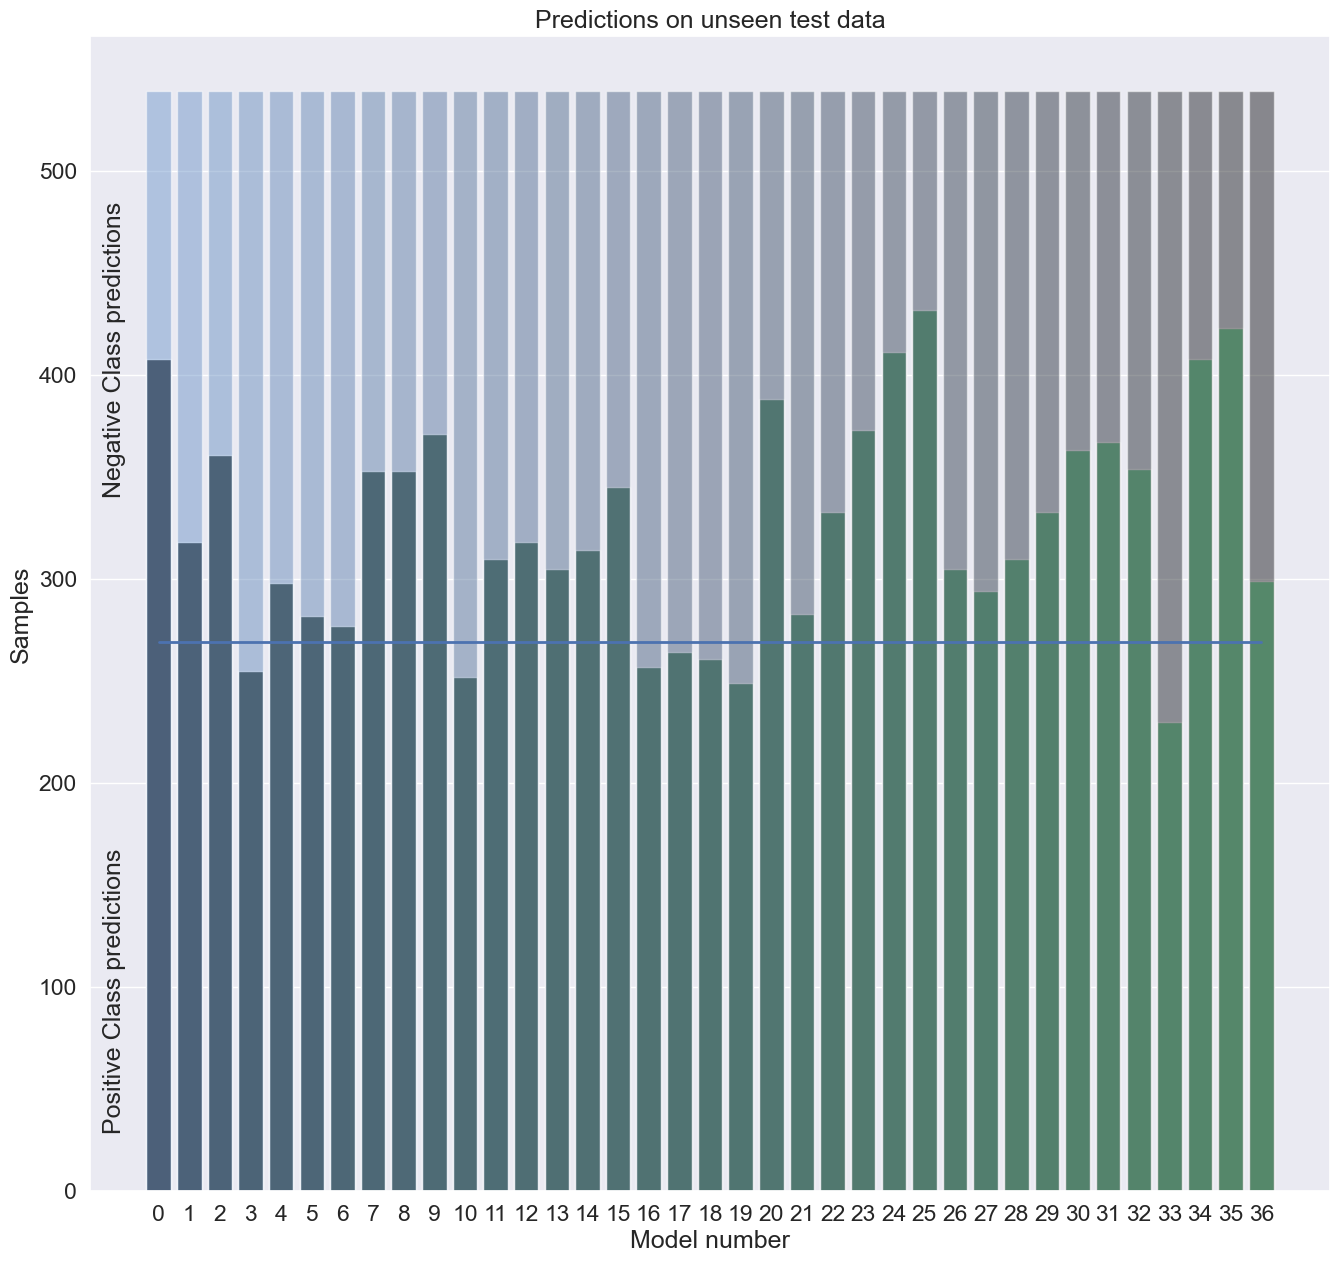

In [52]:
f,ax= plt.subplots(figsize=(16,15))
palette1 = sns.color_palette("light:#5A9", as_cmap=True)
sns.barplot(x=dataframe_for_testing.index, y="pred_1", data = dataframe_for_testing, 
            hue= dataframe_for_testing.index, ax = ax, legend= False, color = '#76fda8').set_title(('Predictions on unseen test data'))
sns.barplot(x=dataframe_for_testing.index, y="sums_preds", data=dataframe_for_testing,
            hue= dataframe_for_testing.index, ax = ax, alpha = 0.5, legend= False,palette = sns.dark_palette("#69d", reverse=True, as_cmap=True))
plt.plot([0, 36], [269, 269], linewidth=2)
plt.text(0.02, 0.05, 'Positive Class predictions',
     horizontalalignment='center',
     verticalalignment='bottom', rotation ='vertical',
     transform = ax.transAxes)
plt.text(0.02, 0.6, 'Negative Class predictions',
     horizontalalignment='center',
     verticalalignment='bottom', rotation ='vertical',
     transform = ax.transAxes)
ax.set(xlabel= 'Model number', ylabel='Samples')
sns.set(font_scale=1.5)
plt.show()

In [ ]:
roc_things1 = pd.DataFrame(roc_things1)
#roc_things1.to_csv('roc_results_for_unseen_data', index = False )

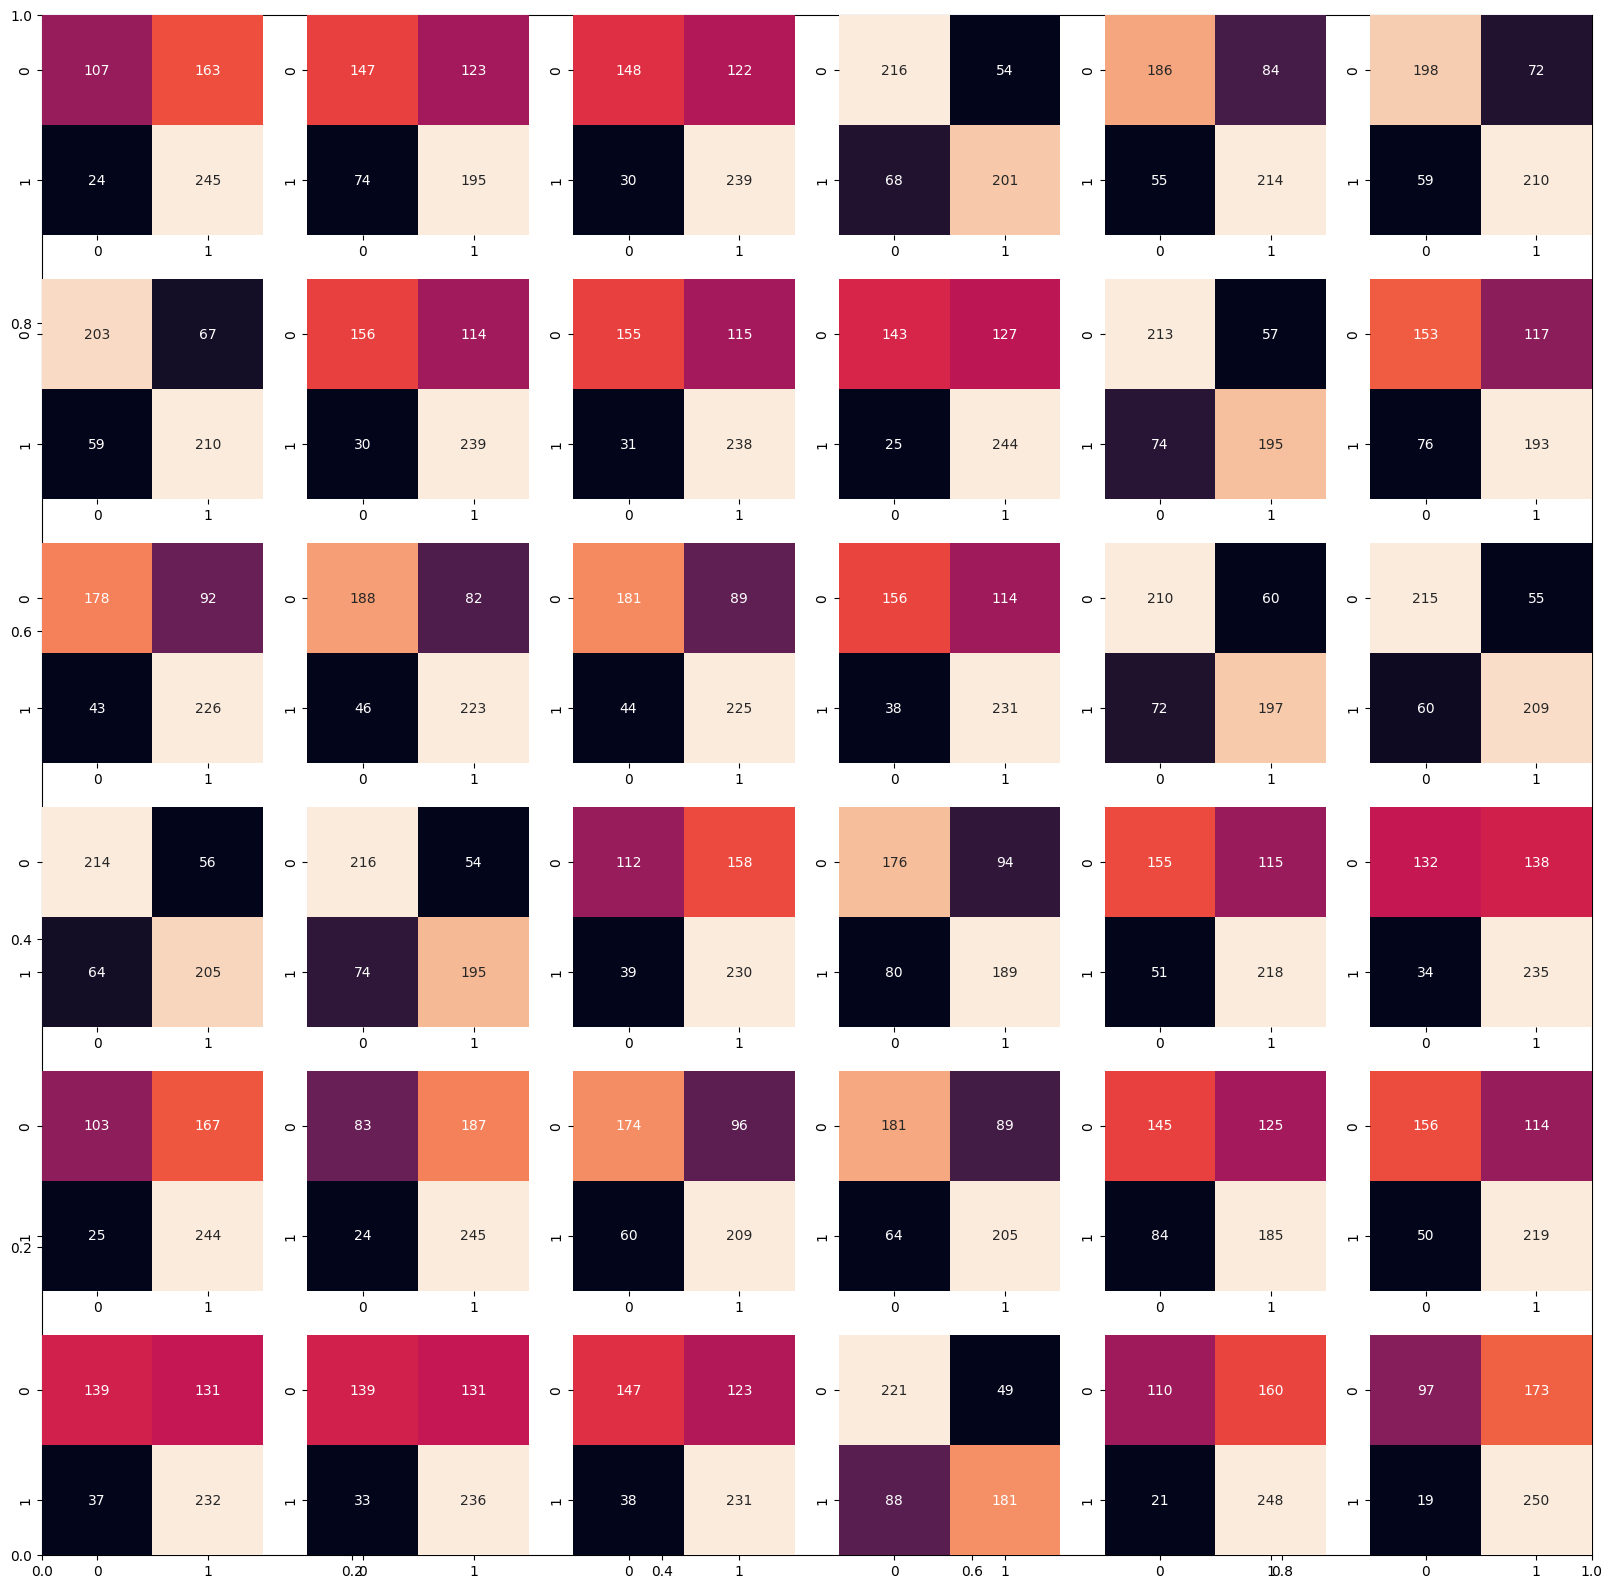

In [60]:

from sklearn.metrics import confusion_matrix
import ast
from sklearn import metrics
fig,ax = plt.subplots(figsize=(20,20))
k = 1
for i in range(0,len(ahh1)-1):

    b = ahh1['y_pred'][i].replace( ' ' , ',' )
    positive_pred = ast.literal_eval(b)
    c = ahh1['y_true'][i].replace( ' ' , ',' )
    true_positive_pred = ast.literal_eval(c)
    matrixes = (confusion_matrix(true_positive_pred,positive_pred))
    plt.subplot(6,6,k)
    sns.heatmap(matrixes, annot=True, cbar= False,fmt='.3g')
    k +=1

Data Analysis - Accuracy

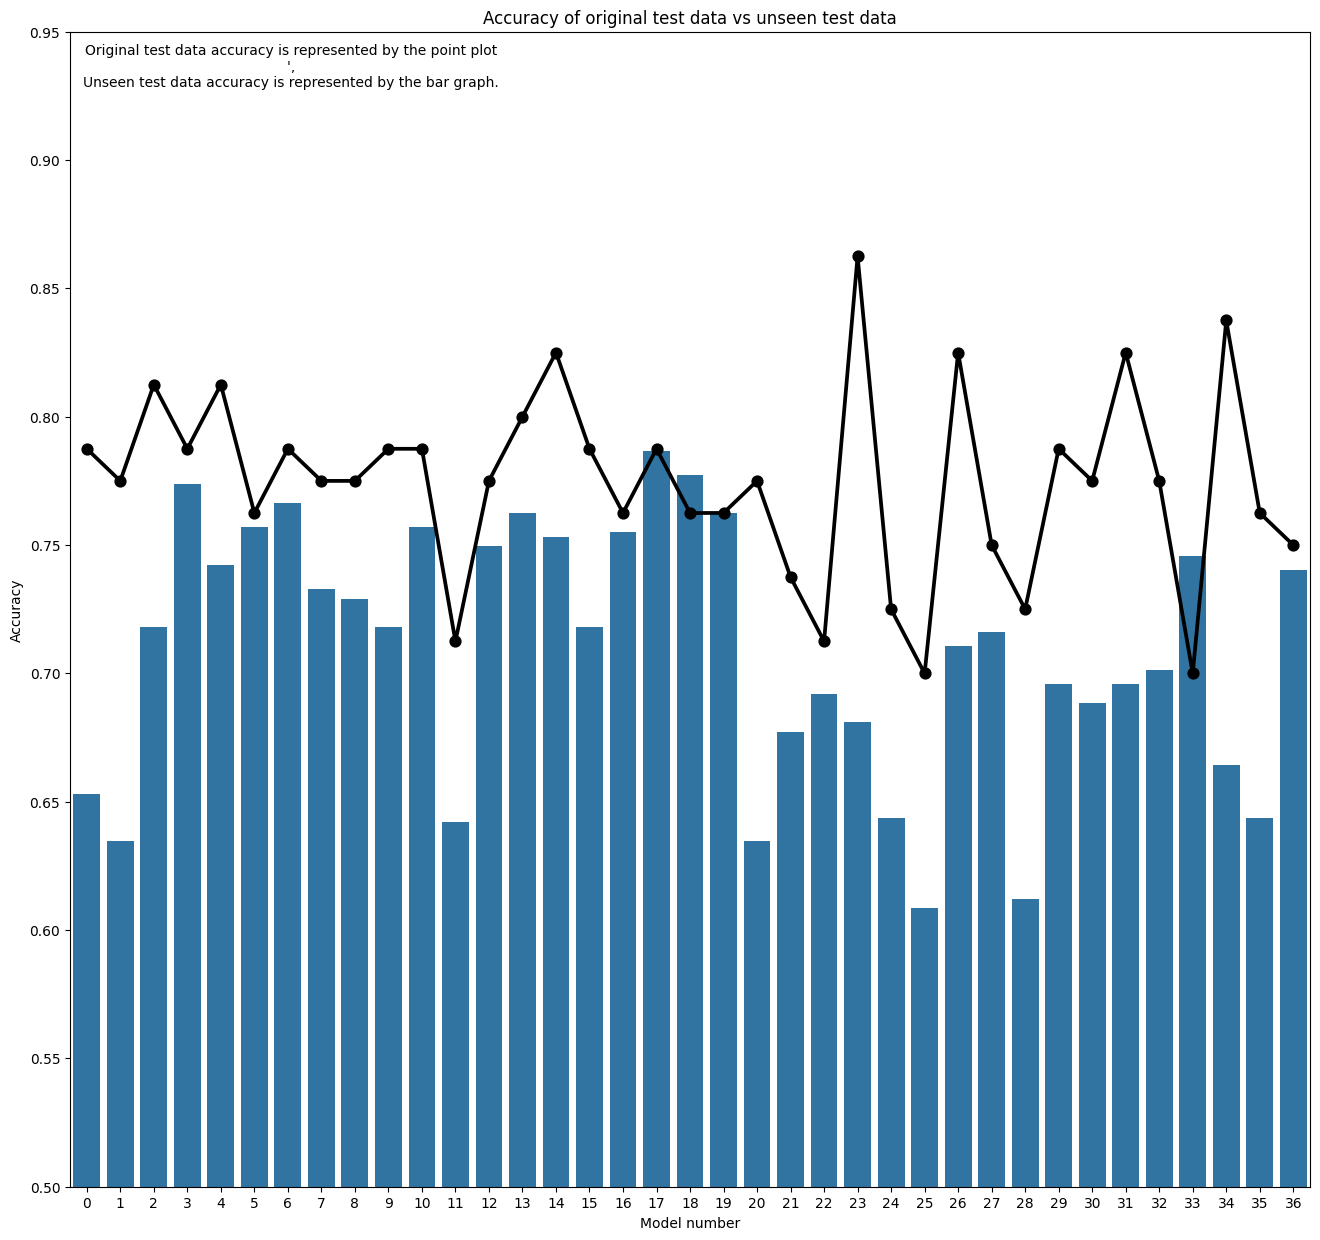

In [19]:
f,ax= plt.subplots(figsize=(16,15))
sns.barplot(x=ahh1.index, y="Accuracy", data = ahh1,
            ax = ax, legend= False).set_title(('Accuracy of original test data vs unseen test data'))
sns.pointplot(x=ahh.index, y="Accuracy", data = ahh, color='black',
             ax = ax, legend= False)
ax.set(ylim=(.50, .95))
ax.set(xlabel= 'Model number')
ax.text(0.18, 0.95, '''Original test data accuracy is represented by the point plot \n', 
Unseen test data accuracy is represented by the bar graph. ''',
     horizontalalignment='center',
     verticalalignment='bottom',
     transform = ax.transAxes)
plt.show()

In [5]:
import statistics
print(' original test data standard deviation:',statistics.stdev(ahh['Accuracy']),'\n',
      'unseen test data standard deviation:', statistics.stdev(ahh1['Accuracy']), '\n',
      statistics.stdev(ahh['Accuracy'])/statistics.stdev(ahh1['Accuracy']),' falls within 0.5-2 can use pooled variance test')


 original test data standard deviation: 0.0377245529051292 
 unseen test data standard deviation: 0.05014885679966562 
 0.7522515030767509  falls within 0.5-2 can use pooled variance test


In [6]:
import statistics
print(' original test data variance:',statistics.variance(ahh['Accuracy']),'\n',
      'unseen test data variance:', statistics.variance(ahh1['Accuracy']))

 original test data variance: 0.001423141891891892 
 unseen test data variance: 0.002514907838313368


In [7]:
print(' original test data mean:',statistics.mean(ahh['Accuracy']),'\n',
      'unseen test data mean:', statistics.mean(ahh1['Accuracy']))

 original test data mean: 0.7743243243243243 
 unseen test data mean: 0.7091711435135135


In [8]:
print(' original test data median:',statistics.median(ahh['Accuracy']),'\n',
      'unseen test data median:', statistics.median(ahh1['Accuracy']))

 original test data median: 0.775 
 unseen test data median: 0.7179963


(array([2., 2., 2., 1., 2., 5., 7., 8., 1., 2., 3., 1., 0., 1.]),
 array([0.7       , 0.71160714, 0.72321429, 0.73482143, 0.74642857,
        0.75803571, 0.76964286, 0.78125   , 0.79285714, 0.80446429,
        0.81607143, 0.82767857, 0.83928571, 0.85089286, 0.8625    ]),
 <BarContainer object of 14 artists>)

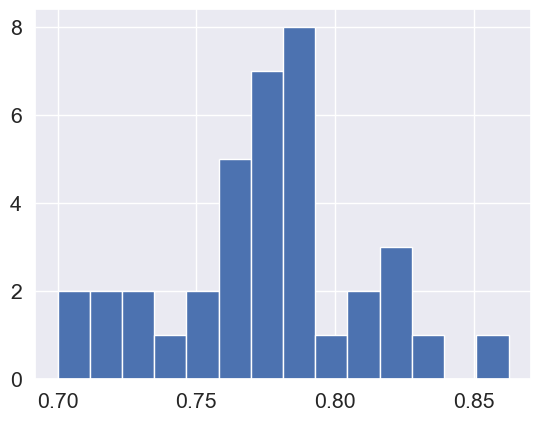

In [66]:
plt.hist(ahh['Accuracy'],bins=14)

(array([2., 0., 5., 1., 1., 2., 4., 1., 5., 2., 3., 5., 4., 2.]),
 array([0.60853434, 0.62125631, 0.63397829, 0.64670026, 0.65942223,
        0.6721442 , 0.68486618, 0.69758815, 0.71031012, 0.7230321 ,
        0.73575407, 0.74847604, 0.76119801, 0.77391999, 0.78664196]),
 <BarContainer object of 14 artists>)

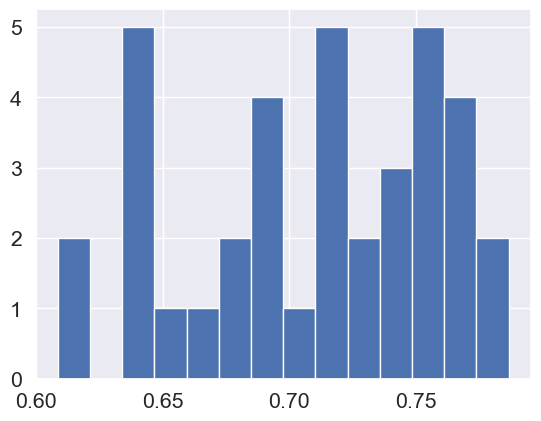

In [67]:
plt.hist(ahh1['Accuracy'], bins= 14)

Do the means of the scores differ?

In [73]:
from scipy import stats



In [21]:
res = stats.normaltest(ahh['Accuracy'])
res

NormaltestResult(statistic=0.15186214094766093, pvalue=0.9268800937631787)

In [19]:
res = stats.normaltest(ahh1['Accuracy'])
res

NormaltestResult(statistic=4.066726118683177, pvalue=0.1308945738787285)

The shapiro wilk test is useful for smaller sample sizes as a test for normality

In [13]:
res = stats.shapiro(ahh['Accuracy'])
res.statistic

0.9642590963325366

In [14]:
res = stats.shapiro(ahh1['Accuracy'])
res.statistic

0.9462349455917501

In [15]:
res = stats.levene(ahh['Accuracy'], ahh1['Accuracy'])
res

LeveneResult(statistic=4.745395836765318, pvalue=0.03265203540502622)

In [22]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['Accuracy'], ahh1['Accuracy'], equal_var= False)
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")


statistic: 6.3153276438, pval: 0.0000000251


In [ ]:
# There are differences between the means but is the first set higher than the second set

In [23]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['Accuracy'], ahh1['Accuracy'], alternative= 'greater', equal_var= False)
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")

statistic: 6.3153276438, pval: 0.0000000125


# Comparing F1 Scores Now


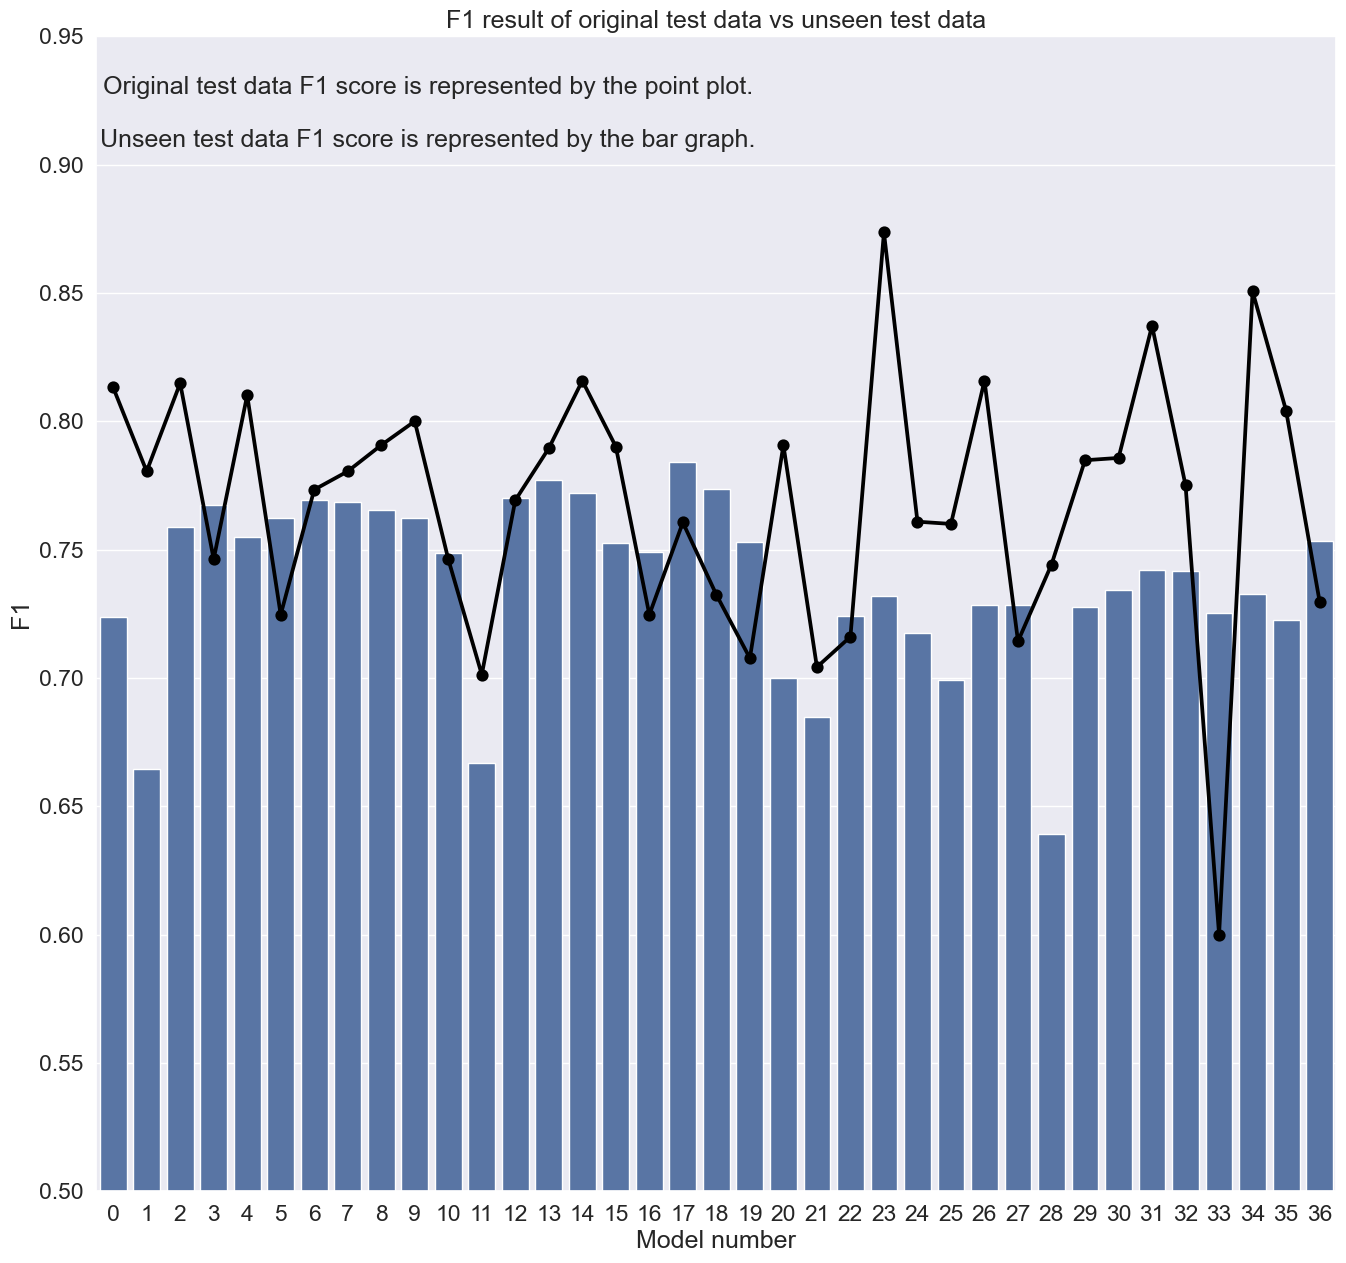

In [135]:
f,ax= plt.subplots(figsize=(16,15))
sns.barplot(x=ahh1.index, y="F1", data = ahh1,
            ax = ax, legend= False).set_title(('F1 result of original test data vs unseen test data'))
sns.pointplot(x=ahh.index, y="F1", data = ahh, color='black',
             ax = ax, legend= False)
ax.set(ylim=(.50, .95))
ax.set(xlabel= 'Model number')
ax.text(0.27, 0.9, '''Original test data F1 score is represented by the point plot. \n 
Unseen test data F1 score is represented by the bar graph. ''',
     horizontalalignment='center',
     verticalalignment='bottom',
     transform = ax.transAxes)
plt.show()

In general the above figure indicates that the results for the unseen data have a narrower spread than for the original test data. With the smallest value being around 65%, (0.65) and the largest being around 80% (0.8). While the original test data result has a minimum value at about 60% (0.6) and a maximum around 85% (0.85). This would suggest that the model performed better on the original test data than on the unseen test data. The table below shows the average score for original test data and unseen test data F1 results. The model performed had a higher average score for the original test data than for unseen. The original data had a score of 76.80% and the unseen test data had a score of 73.72%.

In [137]:
import statistics
print(' original test data mean:',statistics.mean(ahh['F1']),'\n',
      'unseen test data mean:', statistics.mean(ahh1['F1']))

 original test data mean: 0.7680633027027027 
 unseen test data mean: 0.7371905343243244


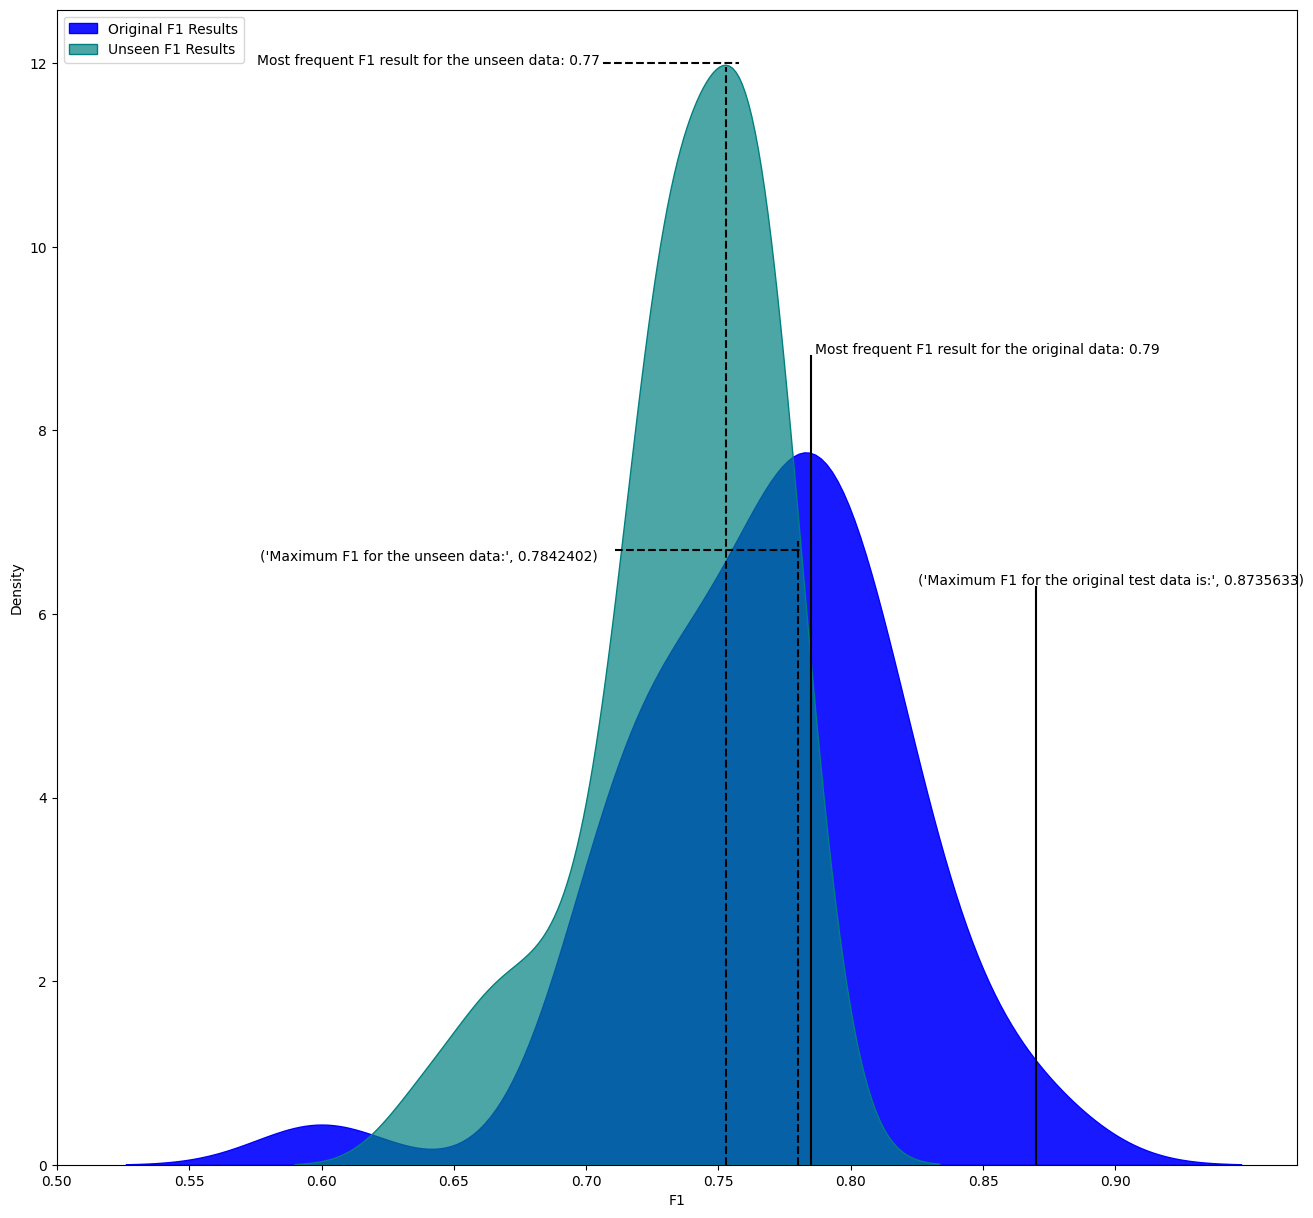

In [185]:
f,ax= plt.subplots(figsize=(16,15))
sns.kdeplot(data=ahh['F1'], ax=ax, fill = True , color= 'Blue', alpha=0.9)
sns.kdeplot(data=ahh1['F1'], ax=ax, fill = True, legend=True, color='Teal', alpha=0.7)
plt.legend(['Original F1 Results','Unseen F1 Results'],loc='upper left')
ax.axvline(x = 0.78,ymin = 0, ymax = 0.54, color = 'black',linestyle='dashed') 
ax.axvline(x = 0.87,ymin = 0, ymax = 0.5, color = 'black') 
ax.axvline(x = 0.785,ymin = 0, ymax = 0.7, color = 'black') 
ax.text(0.85, 0.5,("Maximum F1 for the original test data is:", max(ahh['F1'])),
     horizontalalignment='center',
     verticalalignment='bottom',
     transform = ax.transAxes)
ax.text(0.3, 0.52,("Maximum F1 for the unseen data:", max(ahh1['F1'])),
     horizontalalignment='center',
     verticalalignment='bottom',
     transform = ax.transAxes)
ax.axhline(y = 6.7, xmin = 0.45, xmax = 0.60,
           color = "black", linestyle = "dashed")
ax.axhline(y = 12, xmin = 0.44, xmax = 0.55,
           color = "black", linestyle = "dashed")
ax.axvline(x = 0.753,ymin = 0, ymax = 0.95, color = 'black',linestyle='dashed')
ax.text(0.3, 0.95,("Most frequent F1 result for the unseen data: 0.77"),
     horizontalalignment='center',
     verticalalignment='bottom',
     transform = ax.transAxes)
ax.text(0.75, 0.70,("Most frequent F1 result for the original data: 0.79"),
     horizontalalignment='center',
     verticalalignment='bottom',
     transform = ax.transAxes)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0.5, 0.95, 0.05))

plt.show()

In [94]:
import statistics
print(' original test data standard deviation:',statistics.stdev(ahh['F1']),'\n',
      'unseen test data standard deviation:', statistics.stdev(ahh1['F1']), '\n',
      "95% of values Fall below this value for original test data",(2*statistics.stdev(ahh['F1'])+statistics.mean(ahh['F1'])),
      )

 original test data standard deviation: 0.05076113781991236 
 unseen test data standard deviation: 0.033778768457429775 
 95% of values Fall below this value for original test data 0.8695855783425275


In [110]:
rounded_ah = round(ahh['F1'],2)
rounded_ah1 = round(ahh1['F1'],2)

In [108]:
from collections import Counter

def Most_Common(lst):
    data = Counter(lst)
    return data.most_common(1)

In [109]:
Most_Common(rounded_ah)

[(0.79, 5)]

In [111]:
Most_Common(rounded_ah1)

[(0.77, 7)]

In [138]:
res = stats.shapiro(ahh['F1'])
res.statistic

0.9540014618123527

In [139]:
res = stats.shapiro(ahh1['F1'])
res.statistic

0.9082114037152063

In [140]:
res = stats.levene(ahh['F1'], ahh1['F1'])
res

LeveneResult(statistic=3.572125872480019, pvalue=0.0627824809582574)

In [143]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['F1'], ahh1['F1'])
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")

statistic: 3.0799194939, pval: 0.0029309284


In [144]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['F1'], ahh1['F1'], alternative= 'greater')
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")

statistic: 3.0799194939, pval: 0.0014654642


# Comparing Binary Recall


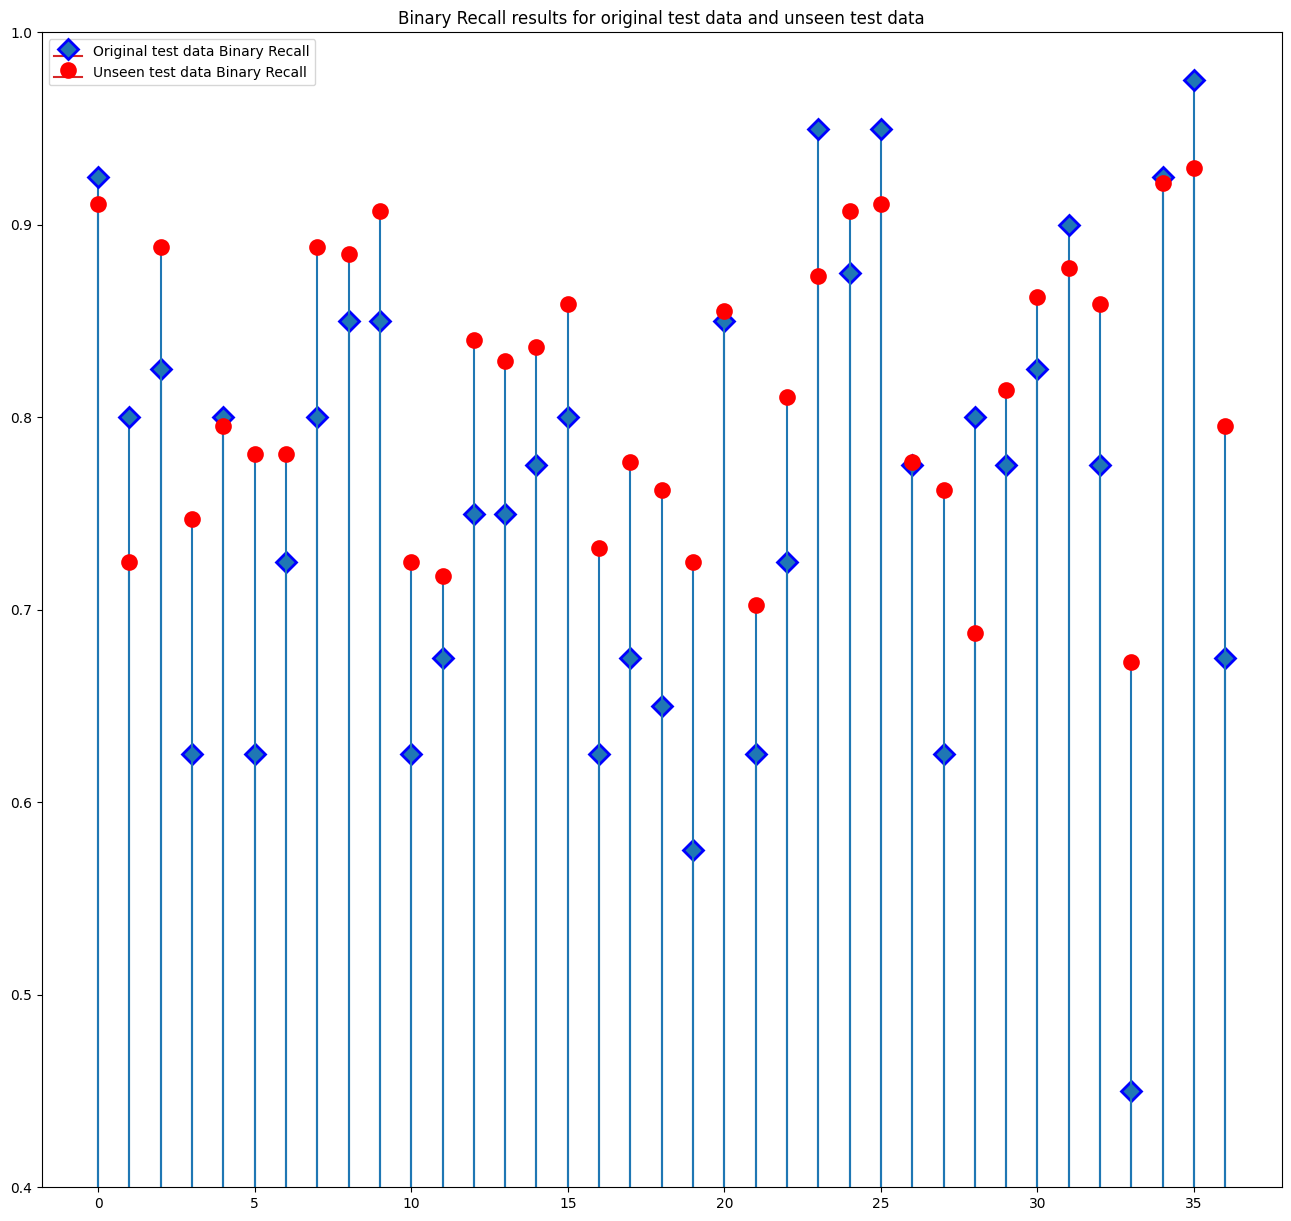

In [226]:

f,ax= plt.subplots(figsize=(16,15))
(markers, stemlines, baseline) = plt.stem(ahh['binary_recall'])
plt.setp(markers, marker='D', markersize=10, markeredgecolor="blue", markeredgewidth=2)
(markers, stemlines, baseline) = plt.stem(ahh1['binary_recall'])
plt.setp(markers, markersize=10, markeredgecolor="red", markeredgewidth=2, color= 'red')
ax.set(ylim=(.4, 1.0))
plt.legend(['Original test data Binary Recall','Unseen test data Binary Recall'],loc='upper left')
plt.title('Binary Recall results for original test data and unseen test data')
plt.show()

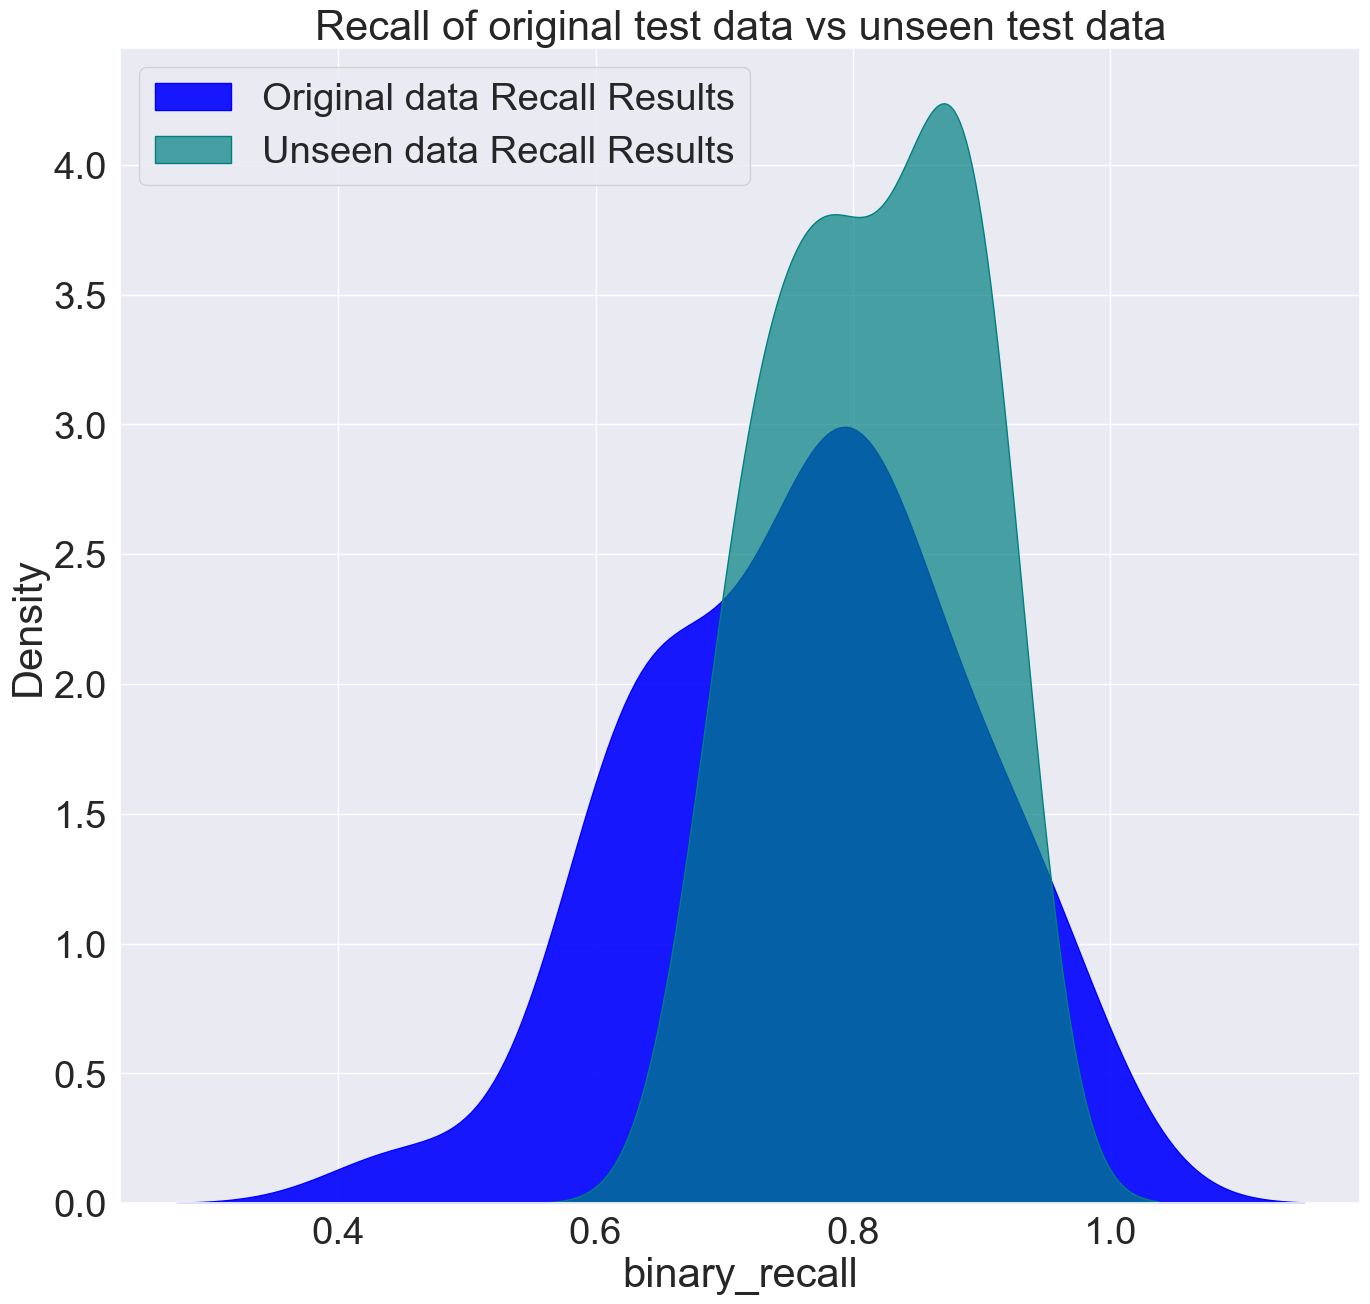

In [94]:
f,ax= plt.subplots(figsize=(16,15))
sns.kdeplot(data=ahh['binary_recall'], ax=ax, fill = True , color= 'Blue', alpha=0.9).set_title(('Recall of original test data vs unseen test data'))
sns.kdeplot(data=ahh1['binary_recall'], ax=ax, fill = True, legend=True, color='Teal', alpha=0.7)
plt.legend(['Original data Recall Results','Unseen data Recall Results'],loc='upper left')
sns.set(font_scale=2.5)

In [63]:
# Binary recall metrics
print("Original test data",np.mean(dataframe_for_micro_test['pred_1'])/np.mean(dataframe_for_micro_test['sums_preds']),
    "Unseen test data",np.mean(dataframe_for_testing['pred_1'])/np.mean(dataframe_for_testing['sums_preds']))

Original test data 0.4878378378378378 Unseen test data 0.6045730331444616


In [61]:
np.mean(ahh['binary_recall'])

0.7621621621621621

In [62]:
np.mean(ahh1['binary_recall'])

0.8143273375675676

(array([1., 0., 1., 7., 3., 4., 9., 5., 2., 5.]),
 array([0.45  , 0.5025, 0.555 , 0.6075, 0.66  , 0.7125, 0.765 , 0.8175,
        0.87  , 0.9225, 0.975 ]),
 <BarContainer object of 10 artists>)

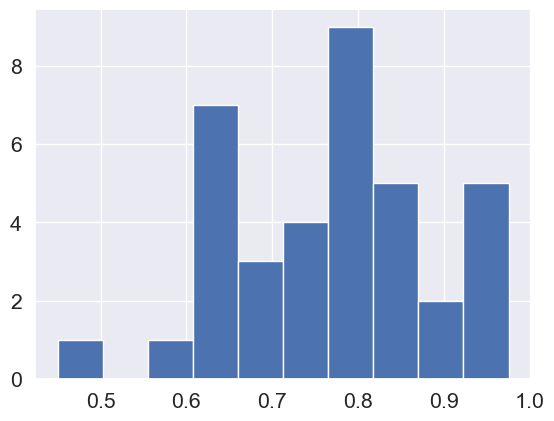

In [64]:
plt.hist(ahh['binary_recall'])

(array([2., 2., 5., 2., 6., 2., 3., 6., 3., 6.]),
 array([0.67286247, 0.69851302, 0.72416358, 0.74981413, 0.77546468,
        0.80111523, 0.82676579, 0.85241634, 0.87806689, 0.90371745,
        0.929368  ]),
 <BarContainer object of 10 artists>)

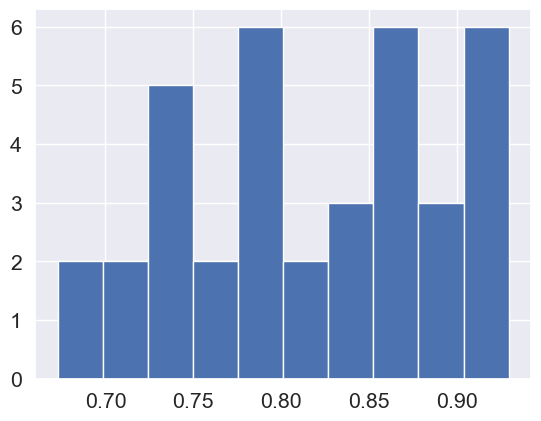

In [65]:
plt.hist(ahh1['binary_recall'])

In [71]:
ahh1.loc[33]

Accuracy                                                     0.745826
F1                                                           0.725451
binary_recall                                                0.672862
binary_precision                                             0.786957
model_info                           best_model_80_accuracy=0.7000.pt
y_pred              [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. ...
y_true              [1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0...
Name: 33, dtype: object

In [74]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['binary_recall'], ahh1['binary_recall'], equal_var= False)
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")

statistic: -2.2421856130, pval: 0.0286701404


In [76]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['binary_recall'], ahh1['binary_recall'], alternative= 'greater', equal_var= False)
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")

statistic: -2.2421856130, pval: 0.9856649298


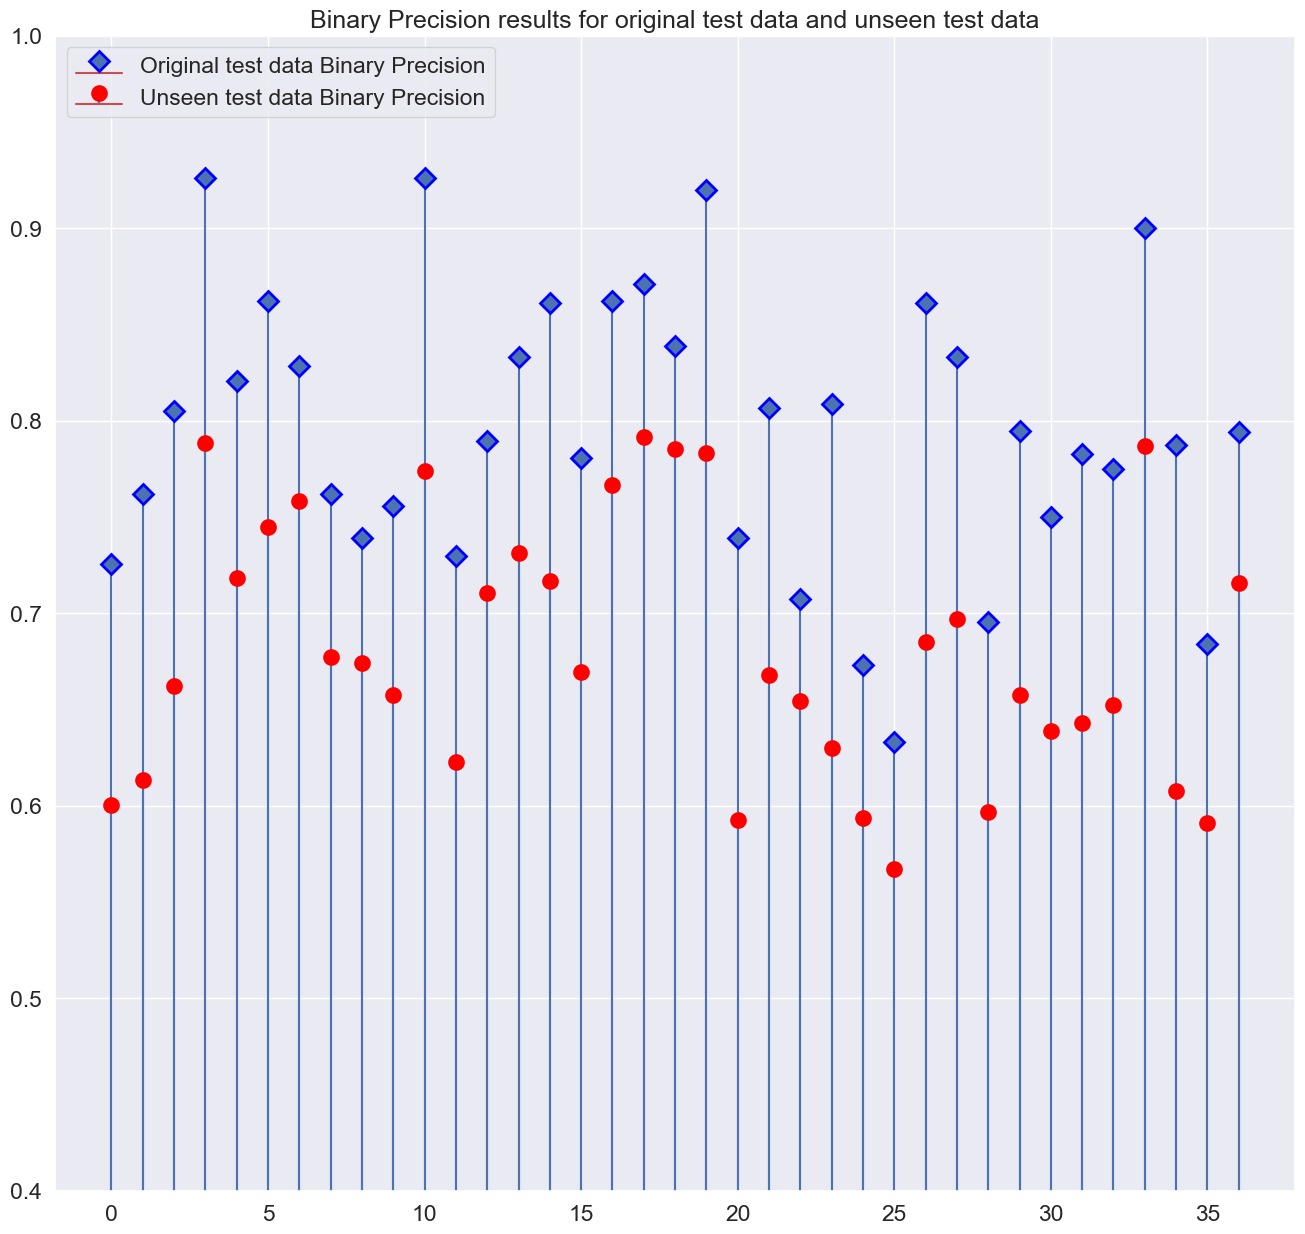

In [79]:
f,ax= plt.subplots(figsize=(16,15))
(markers, stemlines, baseline) = plt.stem(ahh['binary_precision'])
plt.setp(markers, marker='D', markersize=10, markeredgecolor="blue", markeredgewidth=2)
(markers, stemlines, baseline) = plt.stem(ahh1['binary_precision'])
plt.setp(markers, markersize=10, markeredgecolor="red", markeredgewidth=2, color= 'red')
ax.set(ylim=(.4, 1.0))
plt.legend(['Original test data Binary Precision','Unseen test data Binary Precision'],loc='upper left')
plt.title('Binary Precision results for original test data and unseen test data')
plt.show()

In [95]:
np.mean(ahh['binary_precision'])

0.7952354081081079

In [96]:
np.mean(ahh1['binary_precision'])

0.6817382048648649

In [97]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['binary_precision'], ahh1['binary_precision'], equal_var= False)
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")

statistic: 7.0365177117, pval: 0.0000000010


In [98]:
np.set_printoptions(precision=12)

result = stats.ttest_ind(ahh['binary_precision'], ahh1['binary_precision'], alternative= 'greater', equal_var= False)
print(f"statistic: {result.statistic:.10f}, pval: {result.pvalue:.10f}")

statistic: 7.0365177117, pval: 0.0000000005


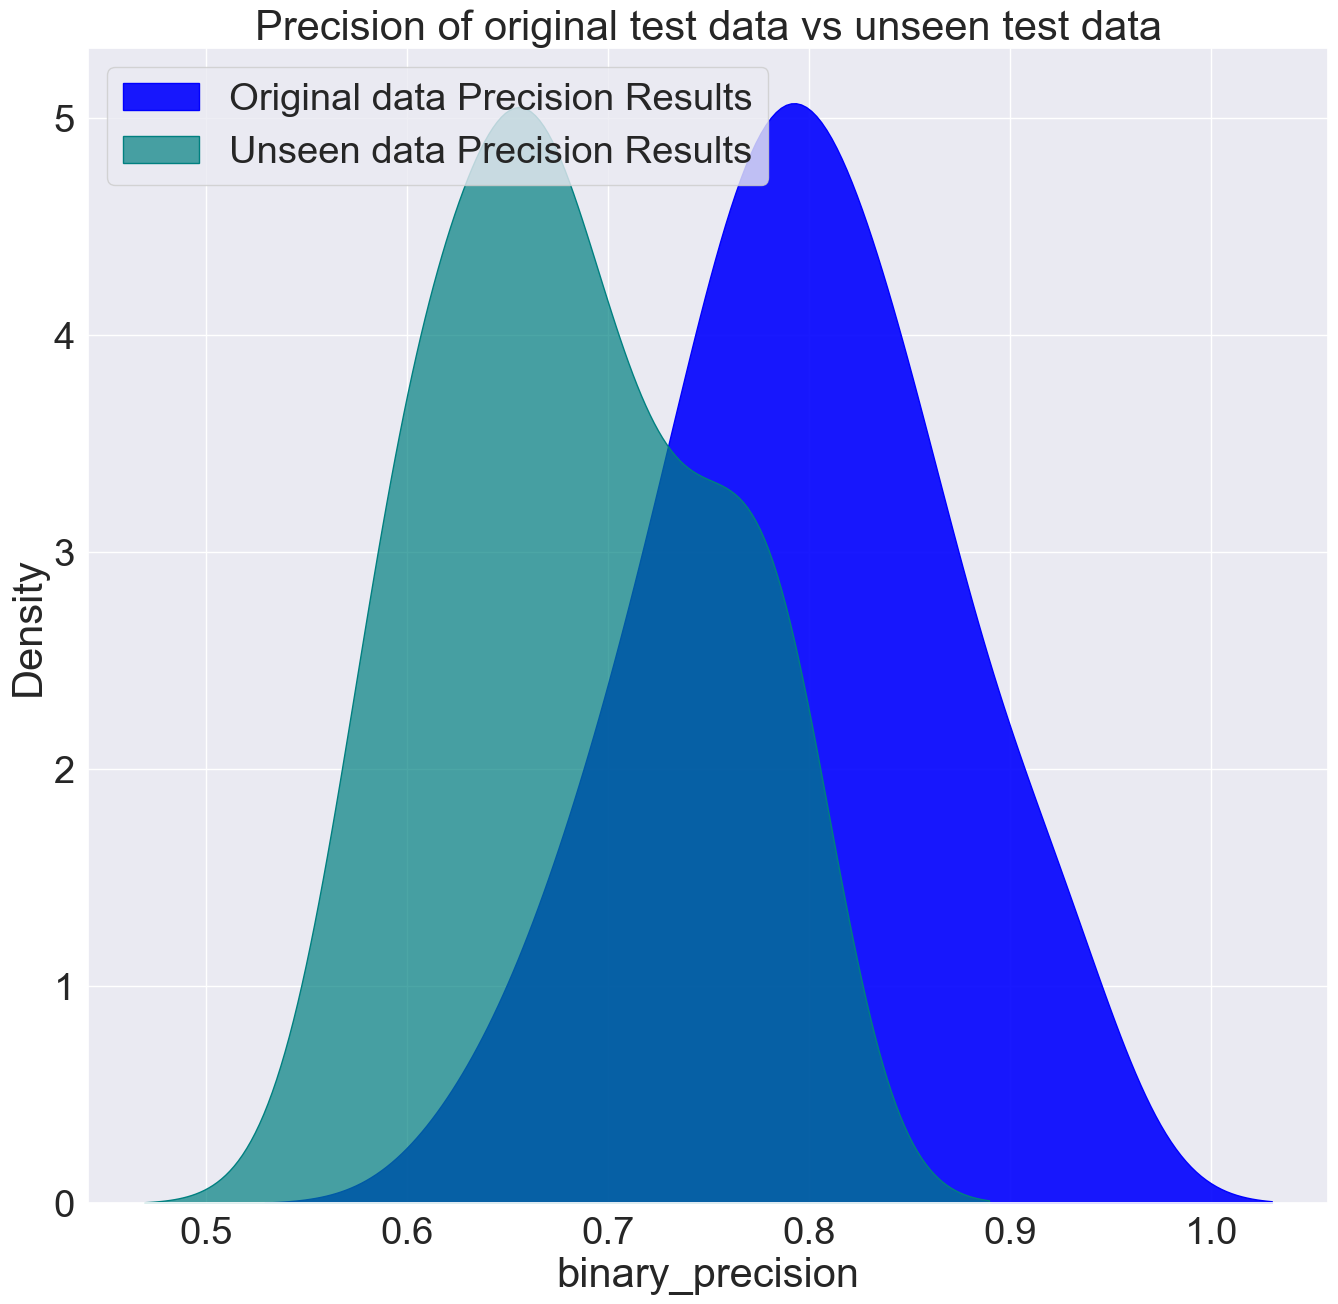

In [99]:
f,ax= plt.subplots(figsize=(16,15))
sns.kdeplot(data=ahh['binary_precision'], ax=ax, fill = True , color= 'Blue', alpha=0.9).set_title(('Precision of original test data vs unseen test data'))
sns.kdeplot(data=ahh1['binary_precision'], ax=ax, fill = True, legend=True, color='Teal', alpha=0.7)
plt.legend(['Original data Precision Results','Unseen data Precision Results'],loc='upper left')
sns.set(font_scale=2.5)

# Choosing best model for the next project

In [12]:
ahh.loc[ahh['Accuracy']==max(ahh['Accuracy'])]

Accuracy        F1  binary_recall  binary_precision  \
23    0.8625  0.873563           0.95          0.808511   

                          model_info  \
23  best_model_35_accuracy=0.7500.pt   

                                               y_pred  \
23  [1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. ...   

                                               y_true  
23  [0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0...

In [33]:
result = pd.merge(ahh, ahh1, on='model_info')


Not as simple as just finding the best initial accuracy it seems

In [39]:
result_sort_accuracy=result.sort_values(by=['Accuracy_y'], ascending=False)



In [42]:
result_sort_accuracy.head(1)

Accuracy_x      F1_x  binary_recall_x  binary_precision_x  \
17      0.7875  0.760563            0.675            0.870968   

                           model_info  \
17  best_model_190_accuracy=0.7750.pt   

                                             y_pred_x  \
17  [0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. ...   

                                             y_true_x  Accuracy_y     F1_y  \
17  [0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0...    0.786642  0.78424   

    binary_recall_y  binary_precision_y  \
17         0.776952            0.791667   

                                             y_pred_y  \
17  [0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. ...   

                                             y_true_y  
17  [1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1...